In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, os, glob, numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
sn.set_context('notebook')

# ECOREG

## Preliminary analysis

Susi and Jannicke have finished preparing the PB and MZB data and I have calculated the IHA parameters for the sites and time periods of interest. Before I get too involved in hypothesis testing and statistical analyses, I want to make sure I understand the data as well as checking the values seem reasonable. This notebook performs some basic exploration of the three datasets: PB, MZB and hydrology, looking for any obvious relationships and sense-checking the values.

### 1. Data reformatting

#### 1.1. MZB data

Jannicke's MZB data for the 61 selected sites are located here:

K:\Avdeling\311 Biologisk mangfold - ferskvann ny\SSC\ECOREG\data_JMO\Metrics_20160530.xlsx

The 1s in the left-hand column mark the metrics to be used in this analysis. Note that Jannicke has calculated metrics for all the sampling times, but we have subsequently selected specific times for each site, so not all the columns are required. Begin by:

 1. Filtering Jannicke's data to only include the metrics of interest (the 1s). <br><br>
 
 2. Deleting the columns for 20/03/2012 at site 107002905 and 27/04/2006 at site 107001160. <br><br>
 
 3. Removing superscripts from metric units.

In addition, some of the Norwegian site codes in the ecology data need changing to match the (correct) NVE codes in the flows data:

 * Site 5.11 should be 50.11 
 * Site 5.13 should be 50.13

The new file is called *jannicke_mzb_metrics_tidied.xlsx*.

#### 1.2. PB data

Susi's PB dataset is here:

K:\Avdeling\311 Biologisk mangfold - ferskvann ny\SSC\ECOREG\ECOREG WP3 PB data.xlsx

The `summary explan resp` sheet includes water chemistry data for each of the 65 PB sites, plus a variety of taxon richness and abundance scores. Note that, at taxon level, the individual abundances are given on a (non-linear) scale of 1 to 5. To give a more accurate reflection of actual abundances, Susi has **cubed** the taxon level abundance scores and then grouped them into general algae categories (red, green, blue and all), summing the cubed scores within each group.

In addition, Susi has also performed **Non-Metric Dimensional Scaling (NMDS)** based on the separate taxon abundance values at each site. NMDS attempts to find a projection or flattening of the high-dimensional data into (in this case) two dimensions, preserving the separation of the sites within the original space as far as possible. Susi has calculated two versions of NMDS, using slightly different subsets of the original data. 

I've copied this file and made the following changes:

 1. Delete unnecessary columns and shorten column names for convenience. <br><br>
 
 2. Delete all plots and any "non-tabular" text in the lower part of the worksheet. <br><br>
 
 3. Correct the site codes for these Norwegian stations:
     * Gryta (6.1 should be 6.10)
     * Gjærdeslåtten (12.13 should be 12.137)
     * Austbygdåi (16.12 should be 16.128)
     * Sønnlandsvatn (16.15 should be 16.155)
 
The new file is called *susi_pb_metrics_and_chem_tidied.xlsx*.

#### 1.3. Susi's preliminary MZB analysis

Susi has already looked at Jannicke's MZB dataset, following a similar procedure to her PB analysis. The `summary MI` sheet of this file:

K:\Avdeling\311 Biologisk mangfold - ferskvann ny\SSC\ECOREG\ECOREG WP3 MI data.xlsx

includes two sets of NMDS scores based on macroinvertebrate abundances. I've copied the file and made the following changes:

 1. Delete all images, "non-tabular" text and unnecessary columns. <br><br>
 
 2. Correct the site code for Gryta (6.1 should be 6.10).
 
The new file is called *susi_mzb_metrics_tidied.xlsx*.

#### 1.4. Spatial co-ordinates

*susi_pb_metrics_and_chem_tidied.xlsx* includes projected co-ordinates for each site, but the Norwegian locations are specified in UTM Zone 32V, while the German ones are in [Gauss-Kruger Germany Zone 3 (EPSG 31493)](http://spatialreference.org/ref/sr-org/6912/). The UTM system is capable of mapping regions of large north-south extent with low distortion: the globe is divided into 60 north-south strips, running from 80 degrees S to 84 degrees N, but each one only 6 degrees of longitude wide (except in a few awkward places, like Norway). Each of these strips is further subdivied for convenience: UTM Zone 32V is a tile belonging to the UTM Zone 32N strip. For reprojection purposes, the co-ordinate system to use for the Norwegian sites is therefore [UTM Zone 32N (EPSG 32632)](http://spatialreference.org/ref/epsg/wgs-84-utm-zone-32n/).

We need to reproject these locations to a common spatial reference system. For detailed mapping, we could consider using a Europe-wide projected co-ordinate system (e.g. the EMEP grid). However, we will most likely be interested in differences between **latitudes**, so to begin with I'll just reproject everything to the [WGS84 geographic co-ordinate system (EPSG 4326)](http://spatialreference.org/ref/epsg/wgs-84/).

In [2]:
# Project site co-ordinates to WGS84 lat/long
from pyproj import Proj, transform

# Read site co-ords
in_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
           r'\Raw_Data\susi_pb_metrics_and_chem_tidied.xlsx')
coords_df = pd.read_excel(in_xlsx, sheetname='summary explan resp')

# Extract cols of interest
coords_df = coords_df[['site', 'east (UTM 32)', 'north (UTM 32)', 'RW_GK3', 'HW_GK3']]

# Separate sites by country
ger_coords = coords_df[pd.notnull(coords_df['RW_GK3'])].copy()
nor_coords = coords_df[pd.notnull(coords_df['east (UTM 32)'])].copy()

# Initialise spatial refs.
# The German projection is obscure and Proj.4 doesn't recognise the EPSG code. Use the Proj.4 definition
# from the link above instead
ger_proj = Proj('+proj=tmerc +lat_0=0 +lon_0=9 +k=1 +x_0=3500000 +y_0=0 +ellps=bessel +units=m +no_defs' )
nor_proj = Proj(init='epsg:32632')
out_proj = Proj(init='epsg:4326')

# Transform Norway
nor_coords['long'], nor_coords['lat'] = transform(nor_proj, 
                                                  out_proj,
                                                  nor_coords['east (UTM 32)'].values,
                                                  nor_coords['north (UTM 32)'].values)

# Transform Germany
ger_coords['long'], ger_coords['lat'] = transform(ger_proj, 
                                                  out_proj,
                                                  ger_coords['RW_GK3'].values,
                                                  ger_coords['HW_GK3'].values)

# Combine
coords_df = pd.concat([ger_coords, nor_coords], axis=0)

# Tidy
coords_df = coords_df[['site', 'long', 'lat']]

coords_df.head()

site      long        lat
0  107000582  6.374454  50.898212
1  107000628  6.481773  50.579289
2  107000671  6.198640  50.773949
3  107001160  7.680440  50.980927
4  107001168  7.602451  51.005076

Let's create a simple map to check these co-ordinates look sensible.

In [3]:
# Map sites
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(15, 15))

# Use a basic Mercator projection
m = Basemap(projection='merc',
            llcrnrlat=45,
            urcrnrlat=65,
            llcrnrlon=-15,
            urcrnrlon=25, 
            lat_ts=0, 
            resolution='i')

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='paleturquoise')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Map (long, lat) to (x, y) for plotting
x, y = m(coords_df['long'].values, coords_df['lat'].values)

# Plot
plt.plot(x, y, 'or', markersize=5)
plt.title('ECOREG site locations', fontsize=18)

This seems to have worked OK. At least, the sites plot in the correct countries and, by eye, the Norwegian locations look comparable to the map in Susi's draft paper. For simplicity in the future, I'll save these co-ordinates to a new file.

In [4]:
# Write co-ords to Excel
out_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
            r'\Raw_Data\site_lat_long_wgs84.xlsx')
coords_df.to_excel(out_xlsx, sheet_name='site_coords')

### 2. Within-dataset exploration and correlation

Many of the ecological and hydrological metrics are similar and likely to be highly correlated. It should therefore be possible to simplify the analysis by removing (or combining) metrics which essentially duplicate the same information. I'd also like to check that values in the various datasets seem sensible before getting stuck into any detailed analysis.

Let's take each dataset in turn.

#### 2.1. MZB data

There are 23 metrics in total in Jannicke's MZB dataset. I'd like to see how they relate to one another, but plotting a 23 by 23 grid will be a bit overwhelming. It looks as though the metrics can be grouped into classes, though: there's a group of "overall" ecological indices; a group of descriptors describing modes of feeding; and a third group describing types of behaviour/activity. Splitting the data into these three groups should make it easier to visualise.

In [5]:
# Read MZB data
mzb_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
            r'\Raw_Data\jannicke_mzb_metrics_tidied.xlsx')
mzb_df = pd.read_excel(mzb_xlsx, sheetname='Metrics', index_col=0)

# Transpose
mzb_df = mzb_df.T
mzb_df.reset_index(inplace=True)

# Add identifer for country
mzb_df['country'] = mzb_df['index'].apply(lambda x: 'N' if x.startswith('S') else 'D' )
mzb_df.index = mzb_df['index']
del mzb_df['index']
mzb_df.index.name = 'site'
mzb_df.head()

Metric     Abundance [ind/m2]  Number of Taxa  \
site                                            
107000582            2224.467            59.0   
107000628            1982.400            71.0   
107000671             480.960            34.0   
107001160            1578.400            45.0   
107001168             330.400            43.0   

Metric     German Saprobic Index (new version)  Average score per Taxon  \
site                                                                      
107000582                                1.889                    5.967   
107000628                                1.650                    6.778   
107000671                                1.791                    6.238   
107001160                                1.594                    6.800   
107001168                                1.928                    5.455   

Metric     Diversity (Shannon-Wiener-Index)  Evenness  \
site                                                    
107000582                             2.865     0.703   
107000628                             3.166     0.743   
107000671                             2.914     0.826   
107001160                             2.583     0.678   
107001168                             2.921     0.777   

Metric     Grazers and scrapers [%]  Miners [%]  Xylophagous Taxa [%]  \
site                                                                    
107000582                    22.009       0.127                 0.173   
107000628                    27.599       0.426                 0.048   
107000671                    38.273       0.931                 0.100   
107001160                    73.142       0.020                 0.000   
107001168                    49.758       0.775                 0.000   

Metric     Shredders [%]   ...     Parasites [%]  Swimming/skating [%]  \
site                       ...                                           
107000582         15.842   ...             1.141                 3.711   
107000628         27.421   ...             2.750                 3.160   
107000671         14.105   ...             1.031                 0.233   
107001160         11.500   ...             0.020                 0.056   
107001168          8.257   ...             0.678                 0.218   

Metric     Swimming/diving [%]  Burrowing/boring [%]  Sprawling/walking [%]  \
site                                                                          
107000582               16.685                 0.953                 37.238   
107000628               16.911                 1.049                 35.054   
107000671               19.062                 2.412                 50.582   
107001160                7.613                 3.229                 10.598   
107001168               16.513                 0.460                 45.061   

Metric     (Semi)sessil [%]  EPT-Taxa [%]  Number of Genera  Life Index  \
site                                                                      
107000582            17.994        30.641              44.0       7.667   
107000628             6.909        31.800              59.0       7.629   
107000671             4.957        37.924              28.0       7.778   
107001160             0.973        55.651              38.0       7.926   
107001168             4.770        38.983              33.0       7.350   

Metric     country  
site                
107000582        D  
107000628        D  
107000671        D  
107001160        D  
107001168        D  

[5 rows x 24 columns]

##### 2.1.1. "Activity" metrics

In [6]:
# Scatter plot matrix of "activity" metrics

# Select columns
act_cols = ['Swimming/skating [%]',
            'Swimming/diving [%]',
            'Burrowing/boring [%]',
            'Sprawling/walking [%]',
            '(Semi)sessil [%]',
            'country']

# Plot
df = mzb_df[act_cols]
sn.pairplot(df, hue='country', diag_kind='kde')

The matrix above shows no clear relationships, but the KDE-smoothed histograms along the diagonal do highlight some obvious differences between German and Norwegian sites. The distribution of (semi-)sessile taxa is broadly the same in both countries, but the distributions for other modes of life are significantly different. In particular, Norway appears to have essentially no burrowing/boring taxa, whereas these are comparatively common in Germany. The German sites also typically have a higher proportion of sprawling/walking and swimming/diving taxa. Swimming/skating taxa are usually scarce at both German and Norwegain sites, although at a handful of locations in Germany they are more prominent.

##### 2.1.2. "Feeding behaviour" metrics

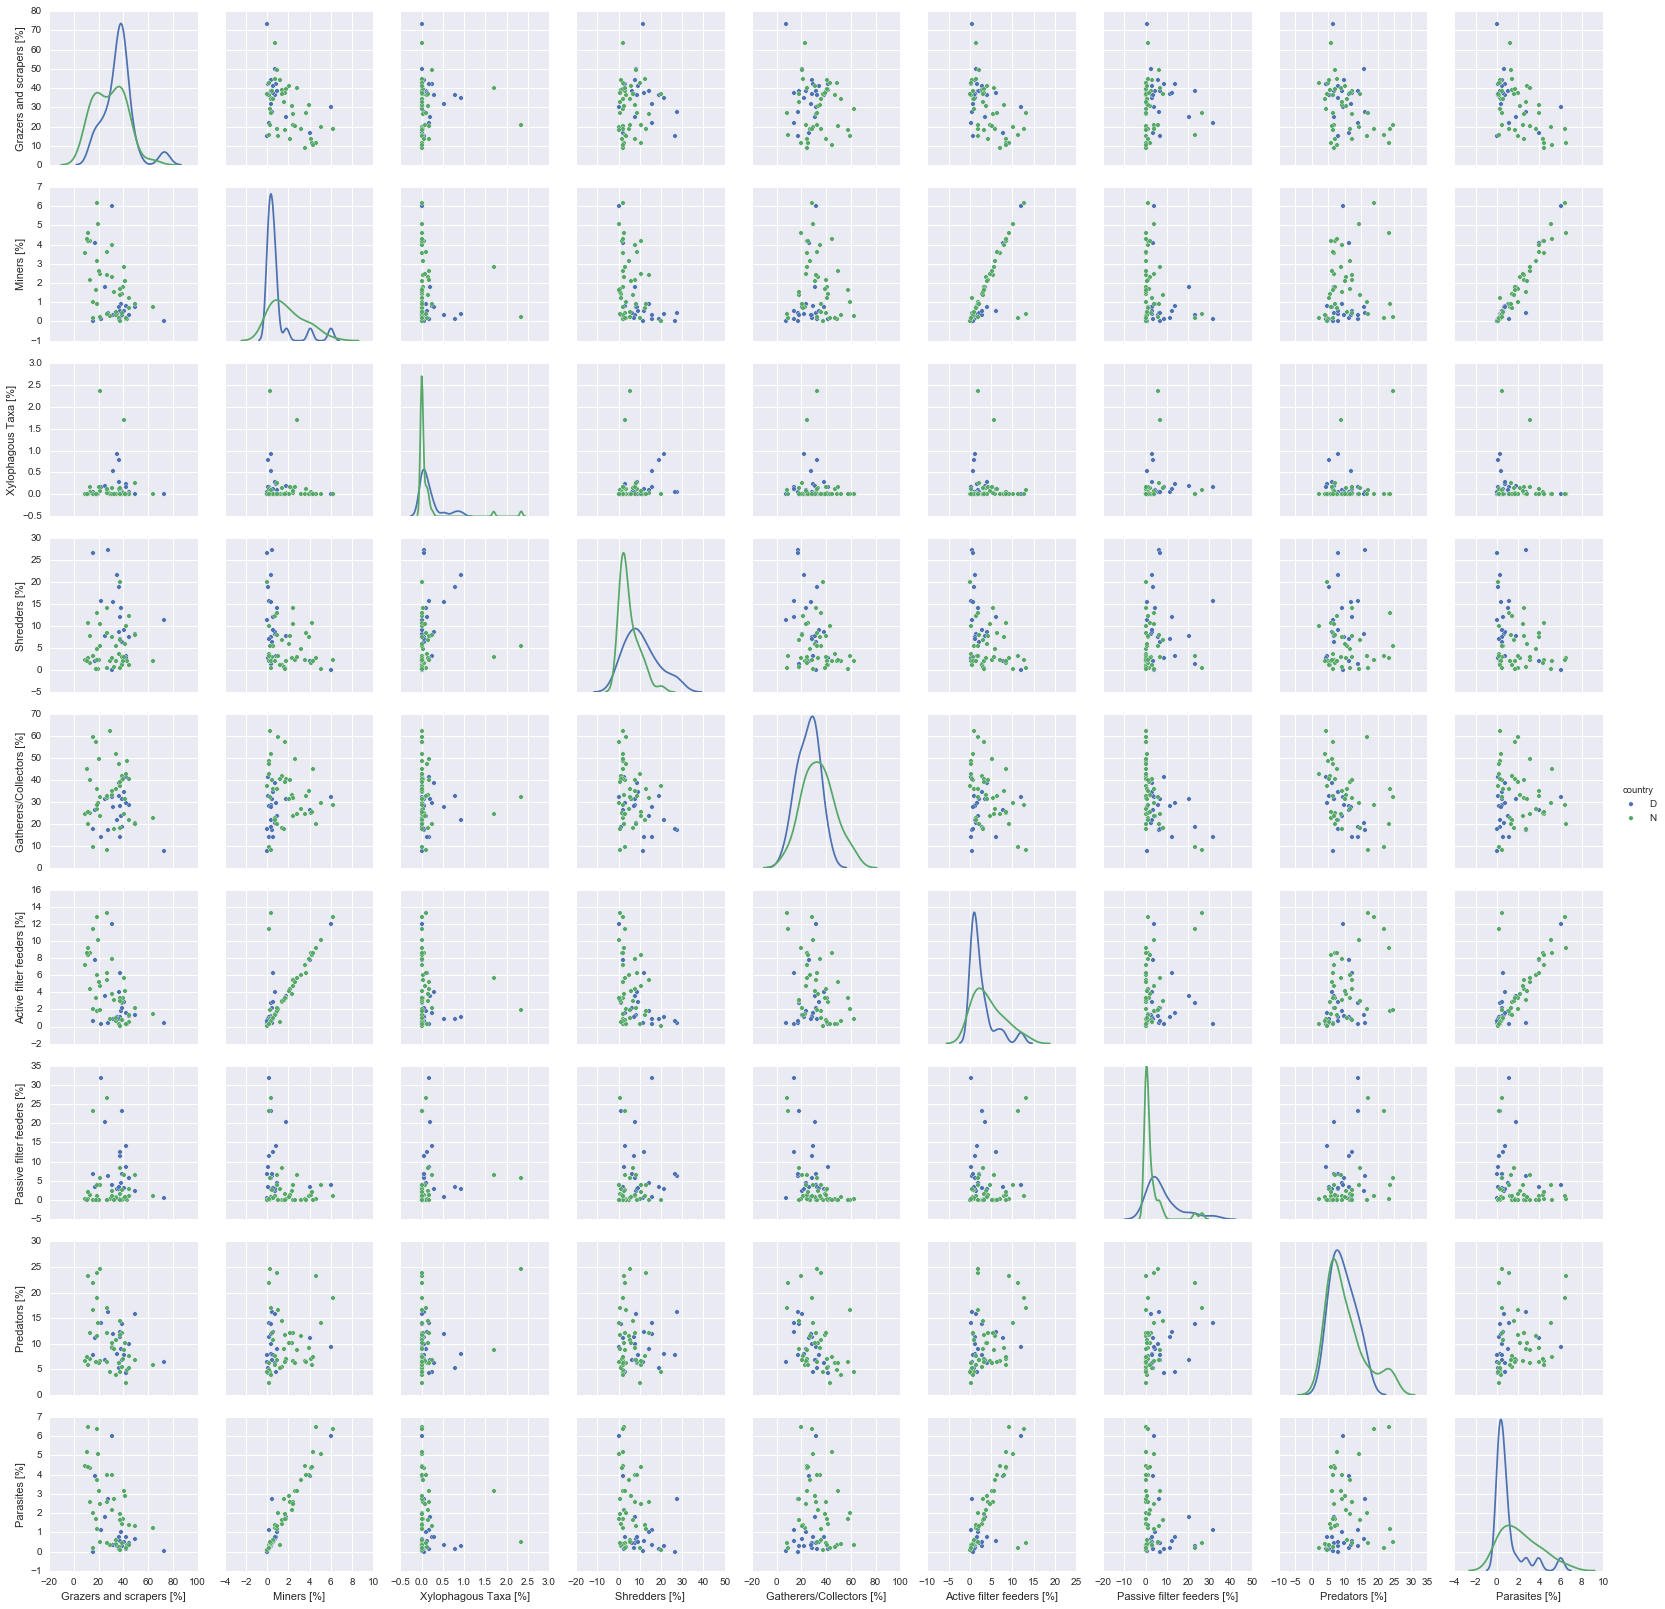

In [7]:
# Scatter plot matrix of "feeding" metrics

# Select columns
feed_cols = ['Grazers and scrapers [%]',
             'Miners [%]',
             'Xylophagous Taxa [%]', # Wood-eating
             'Shredders [%]',
             'Gatherers/Collectors [%]',
             'Active filter feeders [%]',
             'Passive filter feeders [%]',
             'Predators [%]',
             'Parasites [%]',
             'country']

# Plot
df = mzb_df[feed_cols]
sn.pairplot(df, hue='country', diag_kind='kde')

This plot is a bit of a monster, but it does show some clear relationships. The histograms along the diagonal show marked differences between the two countries: the German sites generally have few parasites or miners, whereas the Norwegian sites are more variable. In contrast, shredders and xylophages are quite rare in Norway, but do occur at some locations in Germany. When it comes to filter-feeding, German streams seem to be dominated by passive taxa, whereas the opposite is true in Norway.

In both countries, there is a strong positive correlation between miners and active filter feeders, but the relationship does not extend to passive filter feeders. Unfortunately, I don't know enough about macroinvertebrates to know whether the lifecycles of miners and active filter feeders are closely interlinked(?). Miners are also strongly correlated with parasites, perhaps because some miners *are* parasites? The othe very clear relationship is between parasites and active filter-feeders. Again, this suggests that active filter feeders are commonly parasitised, and perhaps that some miners are also parasites. Check with Susi or Jannicke for some basic ecology knowledge!

##### 2.1.2. "Overall" metrics

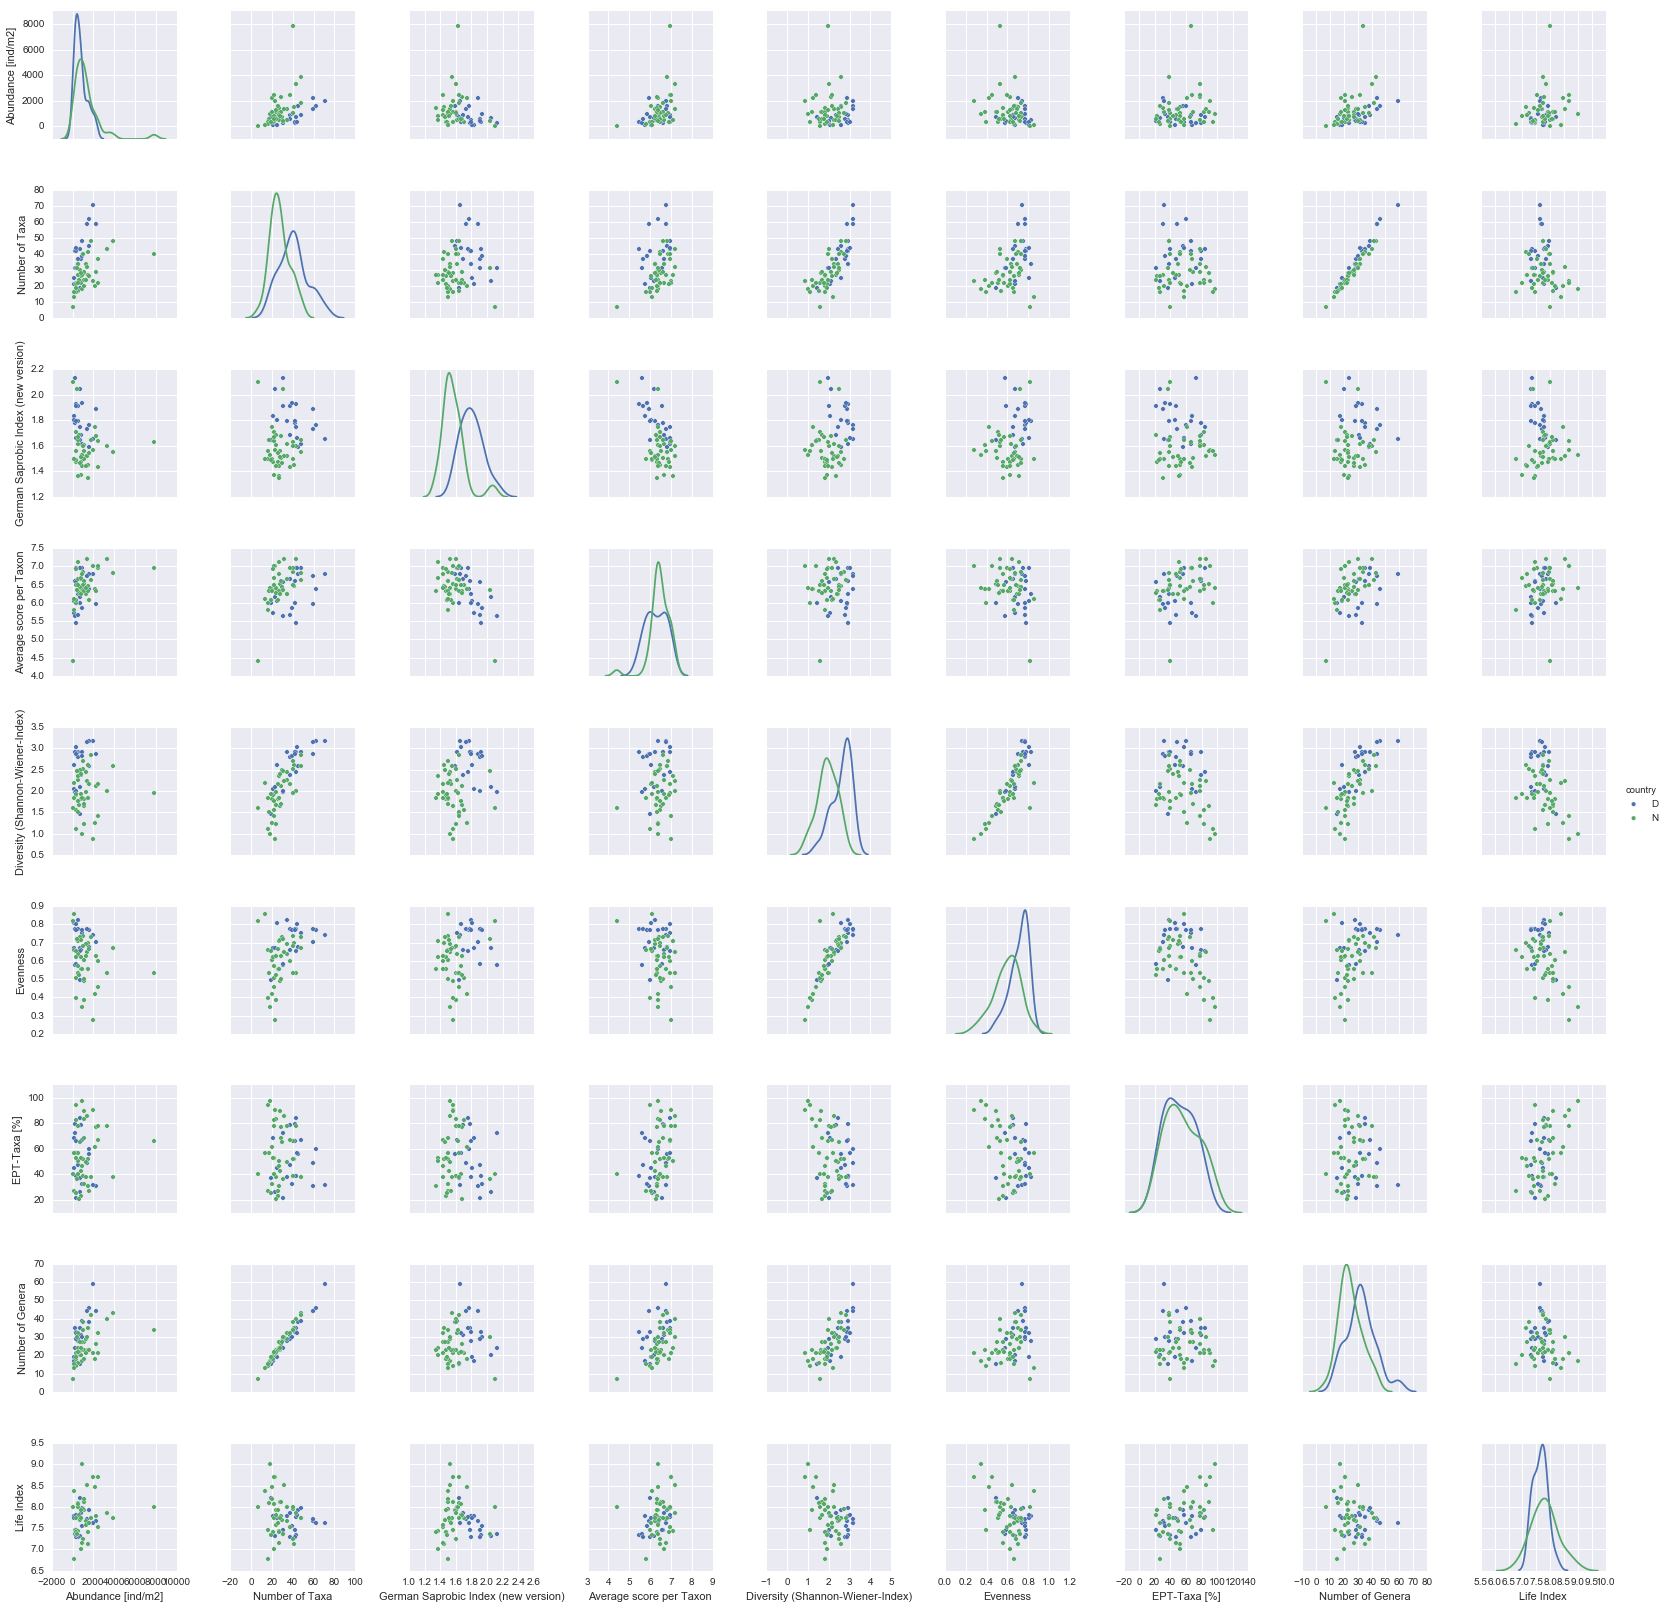

In [8]:
# Scatter plot matrix of "overall" metrics

# Select columns
score_cols = ['Abundance [ind/m2]', 
              'Number of Taxa', 
              'German Saprobic Index (new version)', 
              'Average score per Taxon', 
              'Diversity (Shannon-Wiener-Index)',
              'Evenness',
              'EPT-Taxa [%]',
              'Number of Genera',
              'Life Index',
              'country']

# Plot
df = mzb_df[score_cols]
sn.pairplot(df, hue='country', diag_kind='kde')

This is another hefty scatterplot matrix, but with some interesting patterns. For example, it seems that most German and Norwegian sites have similar overall abundance, but the histogram for Norway is strongly skewed, indicating that a few of the Norwegian sites have very high abundances indeed. On the other hand, the German sites tend to have a larger number of taxa and genera i.e. more diversity (and also greater "evenness", whatever that means). Both countries have very similar distributions of EPT taxa, but the LIFE index for the Norwegian streams is much more variable than for the sites in Germany, albeit with approximately the same overall mean.

There are weak positive correlations between a number of these indices, but by far the clearest relationship is between number of taxa and number of genera, which is reassuring! There's also a (weakly non-linear?) relationship between diversity and evenness, but I don't know enough about these metrics to be able to interpret this.

My overall impression is that these relationships are sensible and there are no really obvious data issues to worry about at this stage.

#### 2.2. PB data

Repeat the same process for the PB data.

In [9]:
# Read PB data
pb_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
           r'\Raw_Data\susi_pb_metrics_and_chem_tidied.xlsx')
pb_df = pd.read_excel(pb_xlsx, sheetname='summary explan resp', index_col=1)

# Extract cols of interest
cols = ['TN', 'TP', 'pH', 'cond', 'TOC',
        'PB rich', 'green rich', 'cyano rich', 'red rich',
        'PB abund', 'green abund', 'cyano abund', 'red abund']
pb_df = pb_df[cols]
pb_df.reset_index(inplace=True)

# Add identifer for country
pb_df['country'] = pb_df['site'].apply(lambda x: 'N' if str(x).startswith('S') else 'D' )
pb_df.index = pb_df['site']
del pb_df['site']
pb_df.index.name='site'

pb_df.head()

TN     TP     pH   cond   TOC  PB rich  green rich  cyano rich  \
site                                                                          
107000582  2.39   20.0  7.900  380.0  3.71        8           3           4   
107000628  3.41   30.0  8.200  310.0  2.60       11           3           4   
107000671  6.10  114.0  8.300  539.0  4.01        2           1           0   
107001160  2.43   30.0  7.655  230.0  2.51        4           2           1   
107001168  5.31  100.0  7.920  462.5  2.46        6           4           1   

           red rich  PB abund  green abund  cyano abund  red abund country  
site                                                                        
107000582         1       137           99           37          1       D  
107000628         2       168            3           11        152       D  
107000671         1        16            8            0          8       D  
107001160         1        37           28            1          8       D  
107001168         1       258          193           64          1       D

##### 2.2.1. Richness and abundance

In [10]:
# Scatter plot matrix

# Select columns
riab_cols = ['PB rich', 'green rich', 'cyano rich', 'red rich',
             'PB abund', 'green abund', 'cyano abund', 'red abund',
             'country']

# Plot
df = pb_df[riab_cols]
sn.pairplot(df, hue='country', diag_kind='kde')

Again, this matrix shows some interesting patterns. The overall PB richness is typically much higher in Norway than it is in Germany, and this difference is primarily accounted for by Norway having a much greater variety of green algae and cyanobacteria. The richness distribution for red algae taxa is broadly the same in both countries. A similar pattern can be seen in the abundance distributions: in general, Norway has significantly higher overall PB abundance than Germany, with especially large numbers of green algae and cyanobacteria. The average abundances of red algae in the two countries are more similar, although the distribution for Germany is broader and significantly right-skewed.

Unlike most of the scatterplots for the MZB data, many of the plots for PB show a clear separation between the German and Norwegian sites, emphasising the marked differences in the histograms (as described above). Perhaps unsurprisingly, there are strong positive correlations between the richness and abundance scores for each group and also between overall richness/abundance and the corresponding richness/abundance scores for the dominant (green and blue) groups of algae.

Based on the plots above, I would expect dimensionality reduction techniques such as PCA or NMDS to show a clear separation of the German and Norwegian sites based on PB assemblages. This will be useful for some types of analysis, but may be problematic for others (e.g. where we'd like to identify a continuous gradient between assemblages).

##### 2.2.2. Chemistry

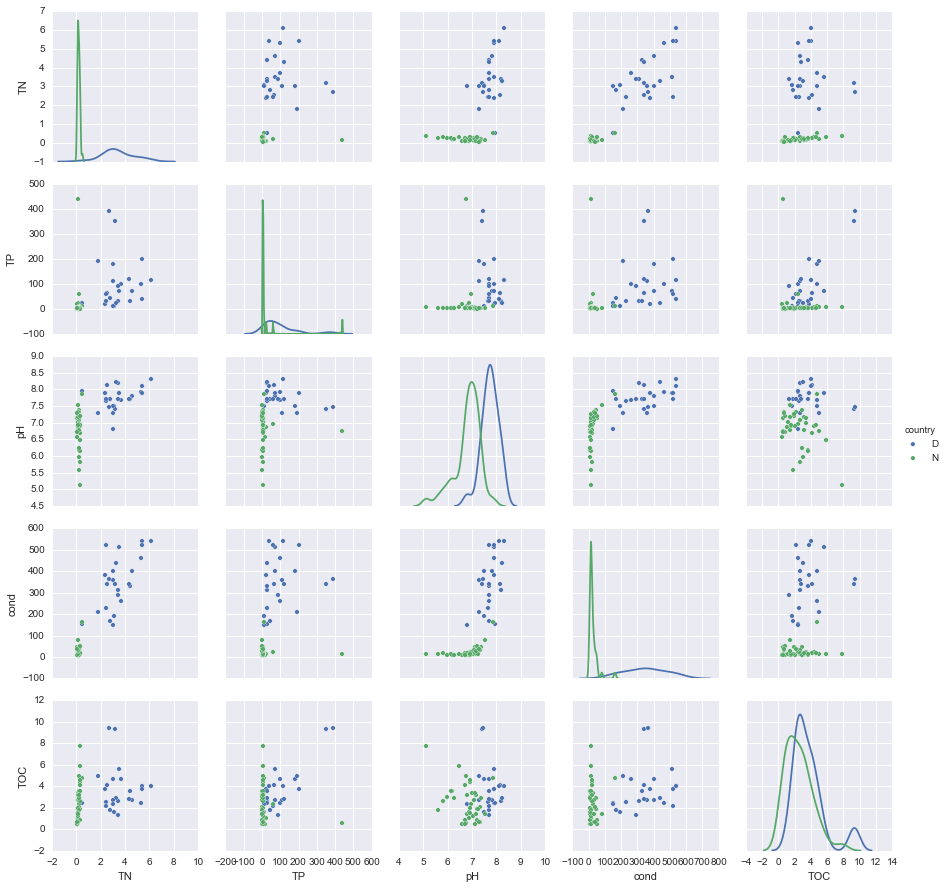

In [11]:
# Scatter plot matrix for chemistry

# Select columns
ch_cols = ['TN', 'TP', 'pH', 'cond', 'TOC',
           'country']

# Plot
df = pb_df[ch_cols]
sn.pairplot(df, hue='country', diag_kind='kde')

There are a few interesting points to note here. First of all, as expected, the Norwegian sites typically have very low concentrations of TN and TP. The exception to this is the site at Akslen (S2.268), which has a TP concentration of nearly $450 \; \mu g /l$. This is extraordinarily high compared to other Norwegian stations and, as both TOC and TN are low at this locality, I strongly **suspect there is a problem with the TP measurement here**. The German sites generally have higher and more variable nutrient concentrations (TN and TP), but the distribution for TOC is broadly similar to that for Norway. 

In terms of pH, Norwegian sites are - unsurprisingly - more acidic and associated with lower conductivity than their German counterparts, which are usually weakly alkaline. There is also a fairly clear exponential relationship between pH and conductivity, which is no surprise either (although I suspect a physical interpretation of this is actually pretty complicated).

#### 2.3. Hydrology

Finally, I'd like to take a look at the IHA parameters. This is a bit more complicated as there's a lot of data here (short term versus long term; relative versus absolute values; PB versus MZB sites etc.). For now, I'll just focus on the PB data, as the MZB data for the 21 common sites use similar time periods, so I'd expect the results for MZB to be more-or-less the same. There should also be essentially no difference between using relative versus absolute values at this stage. 

I would mostly like to sense-check the data and investigate whether the 5 year IHA statistics are significantly different to the 1 year results. 
 
##### 2.3.1. Compare 1 year and 5 year statistics

Let's start by comparing the 1 year and 5 year statistics for PB, using absolute values.

Note that for the **Low** and **High Pulse Length** metrics, there are two sites in the short term data where the IHA software is returning very large negative values. This seems to be a bug/warning associated with pulses crossing year boundaries. I don't think it's a problem for any of the other datasets, so I'm going to set these values to `NaN` for the initial analysis here.

In [12]:
# Read IHA data
iha_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
            r'\IHA_Params\iha_params.xlsx')
short_df = pd.read_excel(iha_xlsx, sheetname='short_term_abs_pb', index_col=0)
long_df = pd.read_excel(iha_xlsx, sheetname='long_term_abs_pb', index_col=0)

# Set large pulse length values in short_df to NaN
short_df.ix[short_df['Low pulse length'] < 0, 'Low pulse length'] = np.nan
short_df.ix[short_df['High pulse length'] < 0, 'High pulse length'] = np.nan

# Get list of IHA params
params = list(short_df.columns)
params.remove('name')

# Scatterplots for each of 33 IHA params
fig, axes = plt.subplots(nrows=6, ncols=6, 
                         sharex=False, sharey=False, 
                         figsize=(15, 15))

# Get axis
ax = axes.ravel()
    
# Loop over plot
for idx, param in enumerate(params):
    # Get values
    sh_vals = short_df[param].values
    lo_vals = long_df[param].values
      
    # Plot
    ax[idx].plot(sh_vals, lo_vals, 'ro') # Data
    ax[idx].plot(sh_vals, sh_vals, 'k-') # Line with gradient 1
    ax[idx].set_title(param)
    ax[idx].set_xlabel('Short term')
    ax[idx].set_ylabel('Long term')

plt.tight_layout()
plt.show()

These plots are interesting. In general, the monthly median flows for one year prior to sampling are very similar to those calculated over 5 years. The main exception is in May when most of the short term values are unusually high compared to the long-term pattern. There is also some evidence of unusually low flows during July, perhaps indicating early, more intense snow melt events followed by drier summers in the short term records. It is also clear that one site in Norway (Storsjøen; S2.611) is *much* bigger than the others.

The time-averaged minimum and maximum flows are broadly comparable between time periods, but in the short term records there are two sites (S30.8 and S50.13) that dry out completely, which is unusual according to the long term average. Interestingly, the base flow index for all sites is higher when calculated using one year of data than it is using 5 years of data. The IHA method calculates base flow index as the 7-day minimum flow divided by the annual mean, and there is some evidence that the 7-day minimum is slightly higher than usual in the short term record. If the annual mean is also a bit lower than normal this could explain the difference, but this **might be worth following up**.

There are relatively poor correlations between the Julian days of the minimum and maximum flows. This could turn out to be ecologically significant, especially in cases where the flow extremes in the one year record occur close to the time of PB or MZB sampling. **It may be worth checking this as well**.

There is a clear positive correlation between the one year and five year datsets for the numbers of low & high pulses, and also for the number of reversals. However, the plots suggest the one year records show less variability than has been typical over the longer time period. In other words, for most of the sites, the year preceding sampling seems to have been relatively stable compared to the longer term average. **Check this too**.

**Actually...**

Based on the above three paragraphs, some of these results looks a bit suspicious to  me. For example, many of the Julian days for minimum and maximum flows lie approximately on a straight line, but other points are more than 150 days offset between the 1 year and 5 year datasets. It also seems strange that the average number of high & low pulses and reversals is significantly higher for the long term record than for the short term one. I have a feeling that the **IHA R package might be doing something odd**.

After a bit of investigation, it is apparent that the software for calculating the IHA parameters is **only** suitable for working with longer time periods and either whole *water years* or whole *calendar years*. At present, I'm selecting time series spanning exactly 1 year and 5 years prior to the ecological sampling, and because these periods are not coincident with calendar years or water years I'm getting **misleading results for the 1 year statistics**. The simplest way to illustrate what's happening is to take the "number of reversals" metric as an example:

Ecological sampling at Norwegian site S50.11 took place on 10/09/2013. If we take the time series for the 1 year period prior to this date and calculate the Group 5 IHA parameters using the R package we get the following results table:
 
|      | Rise rate | Fall rate | Reversals |
|:----:|:---------:|:---------:|:---------:|
| 2012 |   0.49733 |  -0.37923 |       7.0 |
| 2013 |   0.27711 |  -0.05650 |     106.0 |

In other words, even though we've supplied exactly one year's worth of data, the IHA methodology splits it into two hydrological years and calculates the statistics separately for each one: the 2012 values in this table are actually based on just two weeks' data from the second half of September 2012. These results are then combined by taking medians, such that the estimated number of reversals is given by

$$\frac{7 + 106}{2} = 56.5$$

whereas the actual number should be $7 + 106 = 113$. This isn't a problem for the long term datasets, because the issues associated with truncating water years have a negligible effect on the median over 5 years. This explains why the number of reversals in the short term statistics are often roughly half of the (correct) number of reversals in the long term dataset. 

For the number of reversals, this issue can be solved by adding the values in the table above rather than calculating the median. Unfortuantely, this is not the case for most of the other statistics, such as the Julian day of the minimum or maximum flow, or the rise and fall rates. Because the group sizes allocated to each water year are different, there is no simple way of combining these statistics to give a meaningful result (e.g. taking the mean of means only works for equally sized groups).

The overall conclusion is that **my one year IHA statistics have significant errors**, especially for the metrics shown on the bottom two rows of the above scatterplot matrix. The long term statistics, on the other hand, are not badly affected. This is not really a bug in the IHA software - it's just that we're using the indicators in a way they were not designed for. The IHA methodology is specifically for long term (i.e. multi-year) datasets, so if we want to generate similar statistics for short term time series it looks as though I'll have to recode the calculations myself afterall.

**Return to this later**, but for now I'll keep exploring the data.

### 3. Simple linear regression against NMDS

Susi has already identified a number of approximately linear relationships between the PB & MZB NMDS values and some of the water chemistry variables. I'd like to extend this by looking for similar relationships with the hydrology indices, but first I'd like to calculate significance levels for Susi's relationships to see which ones are worth considering in more detail.

We'll start off by defining a convenience function for performing simple linear regression and some basic error diagnostics.

In [13]:
# Linear regression
def lin_reg(df, formula, resp, explan, hue=None):
    """ Function to perform simple (OLS) linear regression.
    
    Args:
        df       Dataframe whose columns include resp and explan
        formula  Regression equation, specified using patsy
        resp     Name of response variable
        explan   Name of explanatory variable
        hue      Split point according to category if desired
    
    Returns:
        None. The function produces the following plots.
            - Summary of the regression output (significant, AIC etc.)
            - Histograms of resp and explan, to help the user decide whether 
              transformation(s) are necessary.
            - Plot of the fitted model, including 95% confidence intervals
              around the fitted lines
            - Plot of residuals to aid model evaluation            
    """
    # Histograms
    fig, axes = plt.subplots(nrows=1, ncols=2)
    sn.distplot(df[explan], kde=True, ax=axes[0])
    sn.distplot(df[resp], kde=True, ax=axes[1])
    axes[0].set_title(explan)
    axes[1].set_title(resp)
    
    # Perform regression
    reg = ols(formula=formula, data=df).fit()
    print reg.summary()

    # Plot
    if hue:
        sn.lmplot(x=explan, y=resp, hue=hue,
                  data=df, size=6, markers=['o', 'x'], 
                  ci=95, palette='Set1')
    else:
        sn.lmplot(x=explan, y=resp,
                  data=df, size=6,
                  ci=95, palette='Set1')
        
    # Plot residuals
    sn.jointplot(x=df[explan], y=reg.resid, 
                 kind='reg', stat_func=None)
    plt.ylabel('Residuals')

#### 3.1. PB data

Now read in the PB data with Susi's NMDS scores.

In [14]:
# Read PB data
pb_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
           r'\Raw_Data\susi_pb_metrics_and_chem_tidied.xlsx')
pb_df = pd.read_excel(pb_xlsx, sheetname='summary explan resp', index_col=1)

# Extract cols of interest
cols = ['TN', 'TP', 'pH', 'cond', 'TOC',
        'NMDS1_PB_all', 'NMDS2_PB_all']
pb_df = pb_df[cols]
pb_df.reset_index(inplace=True)

# Add identifer for country
pb_df['country'] = pb_df['site'].apply(lambda x: 'N' if str(x).startswith('S') else 'D' )
pb_df.index = pb_df['site']
del pb_df['site']
pb_df.index.name='site'

pb_df.head()

TN     TP     pH   cond   TOC  NMDS1_PB_all  NMDS2_PB_all country
site                                                                          
107000582  2.39   20.0  7.900  380.0  3.71     -0.985563      0.050071       D
107000628  3.41   30.0  8.200  310.0  2.60     -0.884119     -1.160233       D
107000671  6.10  114.0  8.300  539.0  4.01     -2.175155      0.211518       D
107001160  2.43   30.0  7.655  230.0  2.51     -1.265485      0.462410       D
107001168  5.31  100.0  7.920  462.5  2.46     -1.252232     -0.396831       D

For PB, Susi found relationships between NMDS1 and pH and between NMDS2 and TP.

##### 3.1.1. NMDS1 and pH

The easiest way to perform the regression is to use `patsy` to specify the linear model (see the [documentation](http://patsy.readthedocs.io/en/latest/formulas.html#the-formula-language) for a quick refresher on the syntax). Susi fitted separate linear regressions to the data for each country, which corresponds to the following model specification

`NMDS1_PB_all ~ pH * C(country)`

This first of all converts the `country` column to a categorical (dummy/indicator) variable. The `*` means that the model includes the two main variables (pH and country), *plus* their interactions. This corresponds to the following general regression model

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2$$

where $x_1$ is pH and $x_2$ is a binary indicator varaiable specifying the country (in this case, 1 = Norway). From the equation above, we can see why this formula actually fits separate linear regressions to the data for each country: when $x_2 = 0$ (for Germany), the last two terms in the equation disappear and we fit a simple linear regression model of the form $y = \beta_0 + \beta_1 x_1$. Similarly, when $x_2 = 1$ (for Norway), we fit a separate simple linear regression to the Norwegian data, where the slope is given by $(\beta_1 + \beta_3)$ and the intercept by $(\beta_0 + \beta_2)$.

                            OLS Regression Results                            
Dep. Variable:           NMDS1_PB_all   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     139.2
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           3.05e-27
Time:                        17:21:58   Log-Likelihood:                -27.981
No. Observations:                  65   AIC:                             63.96
Df Residuals:                      61   BIC:                             72.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.8000      1

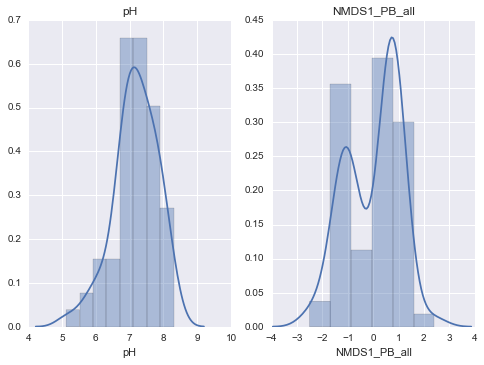

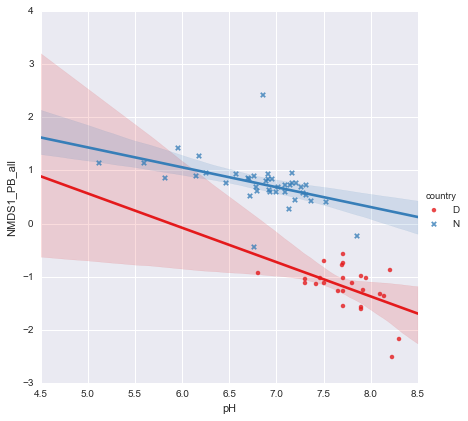

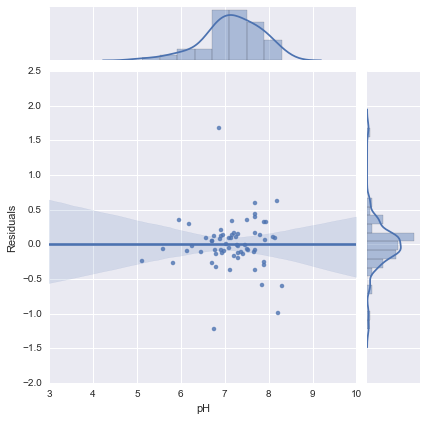

In [36]:
# Regression of NMDS1 against pH, split by country
lin_reg(pb_df, 'NMDS1_PB_all ~ pH * C(country)', 'NMDS1_PB_all', 'pH', hue='country')

The residuals and $R^2$ for this model are OK, but it is clear from width of the 95% confidence interval that the regression line for the German sites is poorly constrained. What's more, the summary output suggests non-significant parameter estimates for the `country` indicator variable and the parameter interactions. This leads me to think that a single linear model (i.e. one line through both sets of points) may be more justified. Let's test this.

                            OLS Regression Results                            
Dep. Variable:           NMDS1_PB_all   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     91.93
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           6.29e-14
Time:                        17:19:42   Log-Likelihood:                -65.687
No. Observations:                  65   AIC:                             135.4
Df Residuals:                      63   BIC:                             139.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.9278      0.935      9.550      0.0

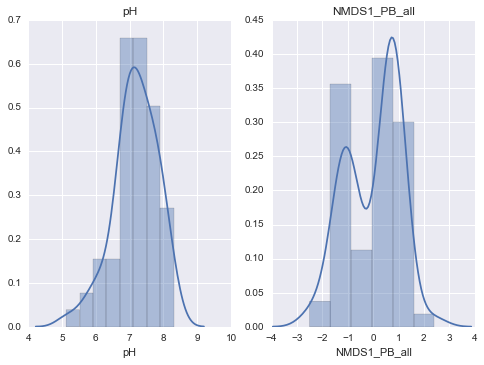

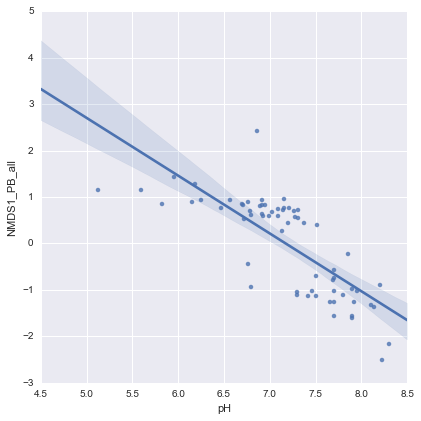

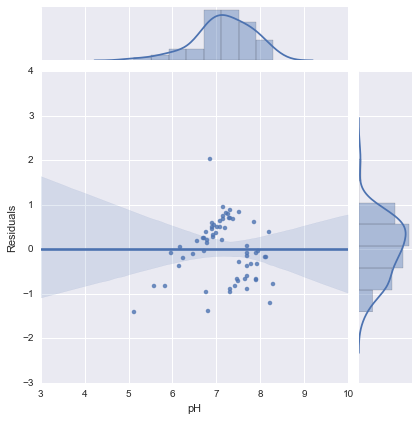

In [16]:
# Regression of NMDS1 against pH, lumped together
lin_reg(pb_df, 'NMDS1_PB_all ~ pH', 'NMDS1_PB_all', 'pH', hue=None)

The parameter estimates here are more significant, but the residuals are horrible and the $R^2$ is lower. The AIC for this model (135.4) is also much larger than for the two-line model (63.96), and smaller values of the AIC imply better (i.e. more likely) models. We can calculate the likelihood ratio between the two options as

$$ LR_i = exp \left[\frac{AIC_{min} − AIC_i}{2} \right] = exp \left[\frac{63.96 - 135.4}{2} \right] \approx 3.10^{-16}$$

In other words, the first (two line) model is *much* better/more likely than the second. Overall, as Susi suspected, **there is evidence for a statistically significant relationship pH and NMDS1** (with slightly different parameter values depending on the country).

##### 3.1.2. NMDS2 and TP

Susi also tried a two-line model for NMDS2 and TP.

                            OLS Regression Results                            
Dep. Variable:           NMDS2_PB_all   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     4.520
Date:                Tue, 14 Jun 2016   Prob (F-statistic):            0.00630
Time:                        17:19:42   Log-Likelihood:                -40.804
No. Observations:                  65   AIC:                             89.61
Df Residuals:                      61   BIC:                             98.30
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             -0.2171      0

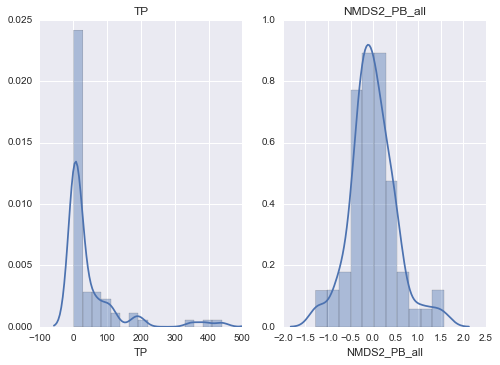

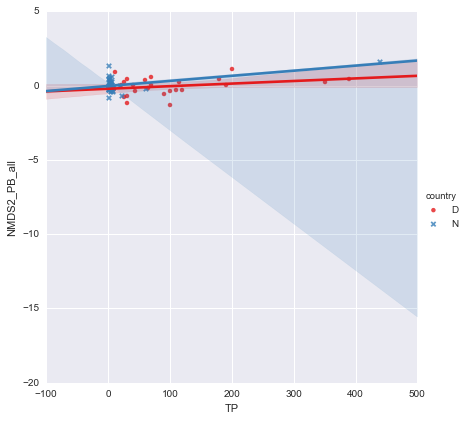

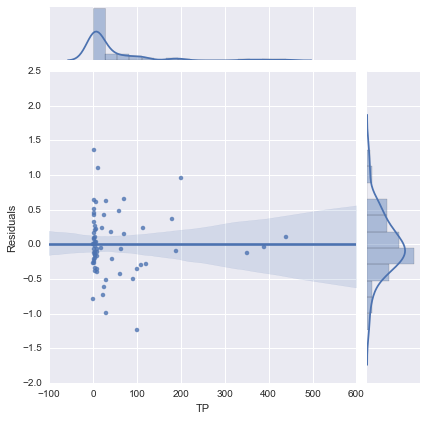

In [17]:
# Regression of NMDS2 against TP, split by country
lin_reg(pb_df, 'NMDS2_PB_all ~ TP * C(country)', 'NMDS2_PB_all', 'TP', hue='country')

Despite the right-skewed distribution for TP, the residuals from this regression are approximately Gaussian, so transformation of the explanatory variable does not appear to be strictly necessary. However, for Norway, the single (erroneous?) large value for TP is very influential, which is perhaps why Susi decided to log-transform the data in her regression model. For comparison, I've repeated this below, but I suspect the overall result will be the same as for the raw (untransformed) data.

The $R^2$ value for the regression above is poor and the curve for Norway is *very* badly constrained - it is essentially determined by the position of a single data point, which I already identified above as a probable error (see section 2.2.2). None of the coefficients are significantly different from zero at the 95% confidence level, so there is no evidence for a relationship here.

Let's also try a version using $log_{10}(TP)$.

                            OLS Regression Results                            
Dep. Variable:           NMDS2_PB_all   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.105
Date:                Tue, 14 Jun 2016   Prob (F-statistic):              0.354
Time:                        17:19:44   Log-Likelihood:                -45.607
No. Observations:                  65   AIC:                             99.21
Df Residuals:                      61   BIC:                             107.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                -0.47

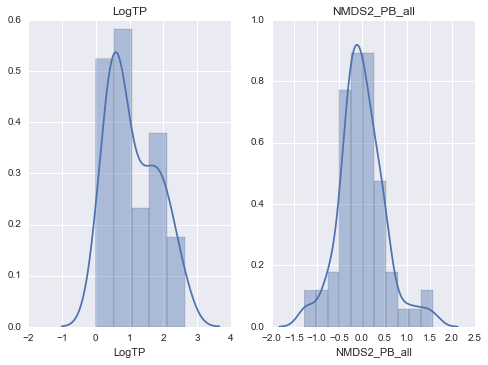

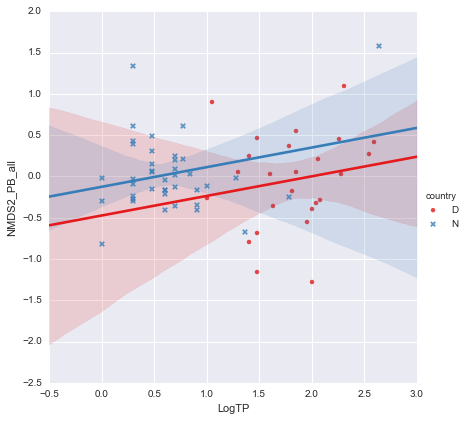

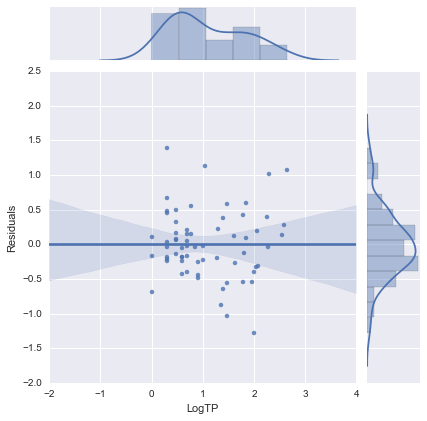

In [18]:
# Log-transform
pb_df['LogTP'] = np.log10(pb_df['TP'])

# Regression of NMDS2 against log10(TP), split by country
lin_reg(pb_df, 'NMDS2_PB_all ~ LogTP * C(country)', 'NMDS2_PB_all', 'LogTP', hue='country')

The results based on the log-transformed data are the same - there is no evidence here for a statistically significant relationship between NMDS2 and TP.

Just for completeness, let's try a single regression line for both countries (using the untransformed data).

                            OLS Regression Results                            
Dep. Variable:           NMDS2_PB_all   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     7.478
Date:                Tue, 14 Jun 2016   Prob (F-statistic):            0.00810
Time:                        17:19:45   Log-Likelihood:                -43.682
No. Observations:                  65   AIC:                             91.36
Df Residuals:                      63   BIC:                             95.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0885      0.068     -1.304      0.1

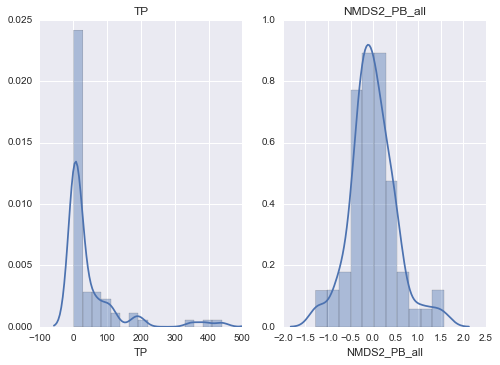

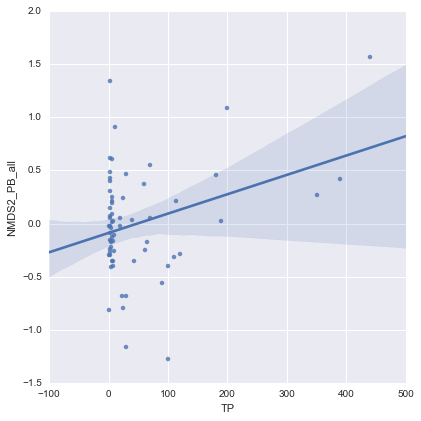

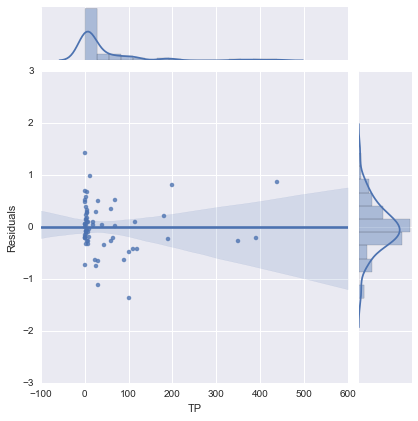

In [19]:
# Regression of NMDS2 against TP, lumped together
lin_reg(pb_df, 'NMDS2_PB_all ~ TP', 'NMDS2_PB_all', 'TP', hue=None)

The slope coefficient for this model *is* significantly different from zero, but the magnitude of the estimate is so small that the strength of the relationship is essentially negligible. What's more, the AIC for this model is slightly larger (i.e. worse) than for the two-line model. The likelihood ratio can be estimated as

$$ LR = exp \left[\frac{89.61 - 91.36}{2} \right] \approx 0.4 $$

So the single line model is approximately 0.4 times as likely as the two-line model, but neither model really explains the data well (the adjusted $R^2$ values for both are less than 15%) and the relationship is either statistically insignificant or so weak as to be considered negligible.

Overall, **there is no evidence for a statistically significant relationship between NMDS2 and TP**.

#### 3.2. MZB data

Susi has also explored relationships between MZB NMDS scores and water chemistry variables such as pH and TOC. As above, it's useful to test the significance of these results.

In [20]:
# Read MZB data
mzb_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
            r'\Raw_Data\susi_mzb_metrics_tidied.xlsx')
mzb_df = pd.read_excel(mzb_xlsx, sheetname='summary MI')

# Add identifer for country
mzb_df['country'] = mzb_df['site'].apply(lambda x: 'N' if str(x).startswith('S') else 'D' )
mzb_df.index = mzb_df['site']
del mzb_df['site']
mzb_df.index.name='site'

mzb_df.head()

NMDS1_MI_morethan4  NMDS2_MI_morethan4  NMDS1_MI_all  NMDS2_MI_all  \
site                                                                            
107000582           -0.975121           -0.174792     -1.142052     -0.093381   
107000628           -1.015112           -0.370154     -1.199426     -0.576073   
107000671           -0.781605           -0.004462     -0.898324      0.017522   
107001160           -1.332343            0.408844     -1.564149     -0.570018   
107001168           -0.863760            0.256564     -1.072799      0.326316   

             TN     TP     pH   cond   TOC country  
site                                                
107000582  2.39   20.0  7.900  380.0  3.71       D  
107000628  3.41   30.0  8.200  310.0  2.60       D  
107000671  6.10  114.0  8.300  539.0  4.01       D  
107001160  2.43   30.0  7.655  230.0  2.51       D  
107001168  5.31  100.0  7.920  462.5  2.46       D

##### 3.2.1. NMDS1 and TOC

There are clearly two approximately linear groups in this dataset, and Susi used a separate regression for each.

                            OLS Regression Results                            
Dep. Variable:           NMDS1_MI_all   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     144.2
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           1.38e-26
Time:                        17:19:46   Log-Likelihood:                -14.758
No. Observations:                  61   AIC:                             37.52
Df Residuals:                      57   BIC:                             45.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -0.9393    

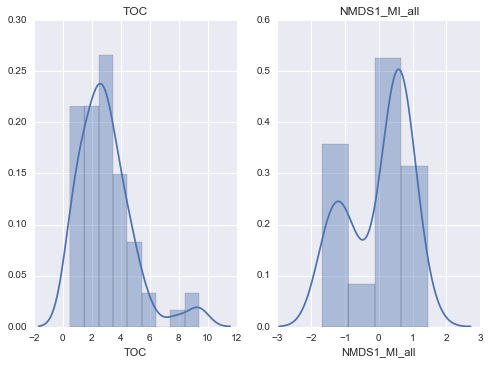

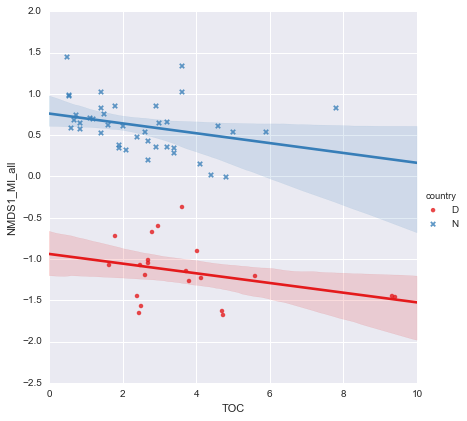

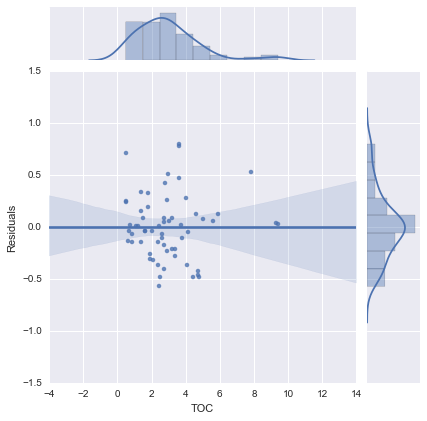

In [21]:
# Regression of NMDS1 against TOC, split by country
lin_reg(mzb_df, 'NMDS1_MI_all ~ TOC * C(country)', 'NMDS1_MI_all', 'TOC', hue='country')

The adjusted $R^2$ value for this model is pretty good (88%) and some of the coefficients are significantly non-zero, but it's worth noting that the key slope relationship (`TOC`) is *not quite* significant at the $p \leq 0.05$ level. In addition, the magnitude of the slope estimate is small, so if there is an effect it's rather weak. It's also interesting to see that the interaction term (`TOC:C(country)[T.N]`) is not at all significant, which means the estimated best-fit slopes are identical for both countries (but with a different offsets/intercepts).

Overall, there is **some evidence here for a statistically (but not ecologically?) significant relationship between NMDS1 and TOC**.

##### 3.2.2. NMDS2 and pH

Susi also tried regressing NMDS2 against pH, but only found a relationship using `NMDS2_MI_morethan4`.

In [22]:
# Regression of NMDS2 against pH, split by country
lin_reg(mzb_df, 'NMDS2_MI_morethan4 ~ pH * C(country)', 'NMDS2_MI_morethan4', 'pH', hue='country')

                            OLS Regression Results                            
Dep. Variable:     NMDS2_MI_morethan4   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.049
Date:                Tue, 14 Jun 2016   Prob (F-statistic):              0.117
Time:                        17:19:47   Log-Likelihood:                -27.370
No. Observations:                  61   AIC:                             62.74
Df Residuals:                      57   BIC:                             71.18
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             -1.9165      1

These regression results are reasonable, but the adjusted $R^2$ value is only 5% and none of the coefficient estimates are anywhere close to being significant. I'm also concerned by how much the regression line for Germany changes if we switch to using `NMDS2_MI_all` instead of `NMDS2_MI_morethan4` (the best-fit line then has a large negative slope). 

Perhaps a one-line regression would be better?

                            OLS Regression Results                            
Dep. Variable:     NMDS2_MI_morethan4   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     4.676
Date:                Tue, 14 Jun 2016   Prob (F-statistic):             0.0346
Time:                        17:19:48   Log-Likelihood:                -28.168
No. Observations:                  61   AIC:                             60.34
Df Residuals:                      59   BIC:                             64.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.1923      0.554     -2.154      0.0

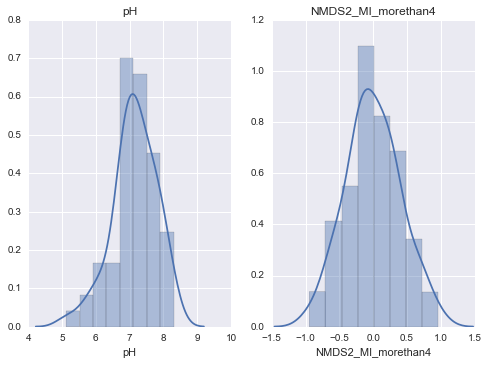

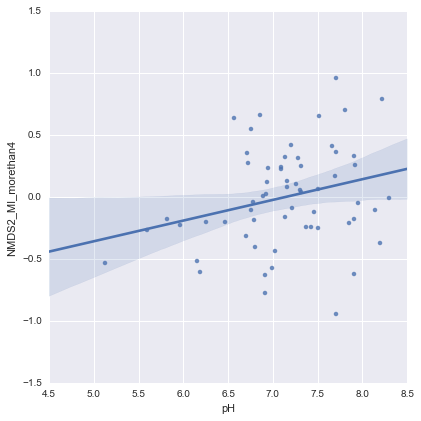

In [23]:
# Regression of NMDS2 against pH, lumped together
lin_reg(mzb_df, 'NMDS2_MI_morethan4 ~ pH', 'NMDS2_MI_morethan4', 'pH', hue=None)

This is clearly a better model - the coefficients are significant and the AIC is lower. It is also fairly robust to switching between `NMDS2_MI_all` and `NMDS2_MI_morethan4`, which is a substantial improvement. However, the adjusted $R^2$ is still very low (~6%).

Overall, **there is a very weak (but statistically significant) relationship between NMDS2 and pH** but, in my opinion, it is **unlikely to be ecologically important**.

#### 3.3. Hydrology data

Finally, I would like to quickly explore the relationships between NMDS values and the long term, relative IHA indices. This will generate a lot of plots. If any of them look promising, we can explore their significance in more detail using the same workflow as above.

To start off, we need to read in the IHA data for long term, relative values and then join in the PB scores for NMDS1 and NMDS2.

In [24]:
# Read long term relative data
iha_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
            r'\IHA_Params\iha_params.xlsx')
long_df = pd.read_excel(iha_xlsx, sheetname='long_term_rel_pb')

# Add identifer for country
long_df['country'] = long_df['site'].apply(lambda x: 'N' if str(x).startswith('S') else 'D' )

# The 'name' column is not needed
del long_df['name']

# Join in NMDS1 and NMDS2 for PB
long_df.index = long_df['site']
del long_df['site']
long_df = pd.merge(long_df, pb_df[['NMDS1_PB_all', 'NMDS2_PB_all']], 
                   how='left', left_index=True, right_index=True)
long_df.reset_index(inplace=True)

long_df.head()

site   October  November  December   January  February     March  \
0   S109.2  0.488282  0.267673  0.193484  0.128589  0.116837  0.133095   
1  S109.21  0.619327  0.441741  0.309823  0.202087  0.163971  0.142708   
2   S109.9  0.408175  0.197541  0.117353  0.067125  0.058857  0.053659   
3  S12.137  0.839181  0.763003  0.771087  0.725656  0.710248  0.621086   
4    S12.2  0.573257  0.485983  0.261844  0.174036  0.158166  0.145911   

      April       May      June      ...       Low pulse number  \
0  0.343688  1.468724  2.651497      ...                    2.0   
1  0.247567  1.215175  1.908520      ...                    2.5   
2  0.162495  1.334429  2.769032      ...                    2.0   
3  0.470380  0.867902  1.404351      ...                   15.0   
4  0.562158  1.903437  1.146696      ...                    1.5   

   Low pulse length  High pulse number  High pulse length  Rise rate  \
0              50.5                5.0                4.5   0.049026   
1               4.5                8.0                9.5   0.034089   
2              62.0                5.0                5.0   0.039495   
3               2.0               11.5                3.0   0.048921   
4              55.5                7.0                7.0   0.053594   

   Fall rate  Reversals  country  NMDS1_PB_all  NMDS2_PB_all  
0  -0.023184      119.5        N      0.447565     -0.293245  
1  -0.025441      131.5        N      0.541355     -0.355033  
2  -0.020583      110.0        N      0.574073     -0.131012  
3  -0.046179      165.0        N      0.685343     -0.218636  
4  -0.030547       92.5        N      0.594310     -0.237593  

[5 rows x 37 columns]

##### 3.3.1. IHA and NMDS for PB

We'll begin by regressing NMDS1 for the PB data against each of the IHA metrics. For the moment, we'll fit a separate regression line to the data for each country.

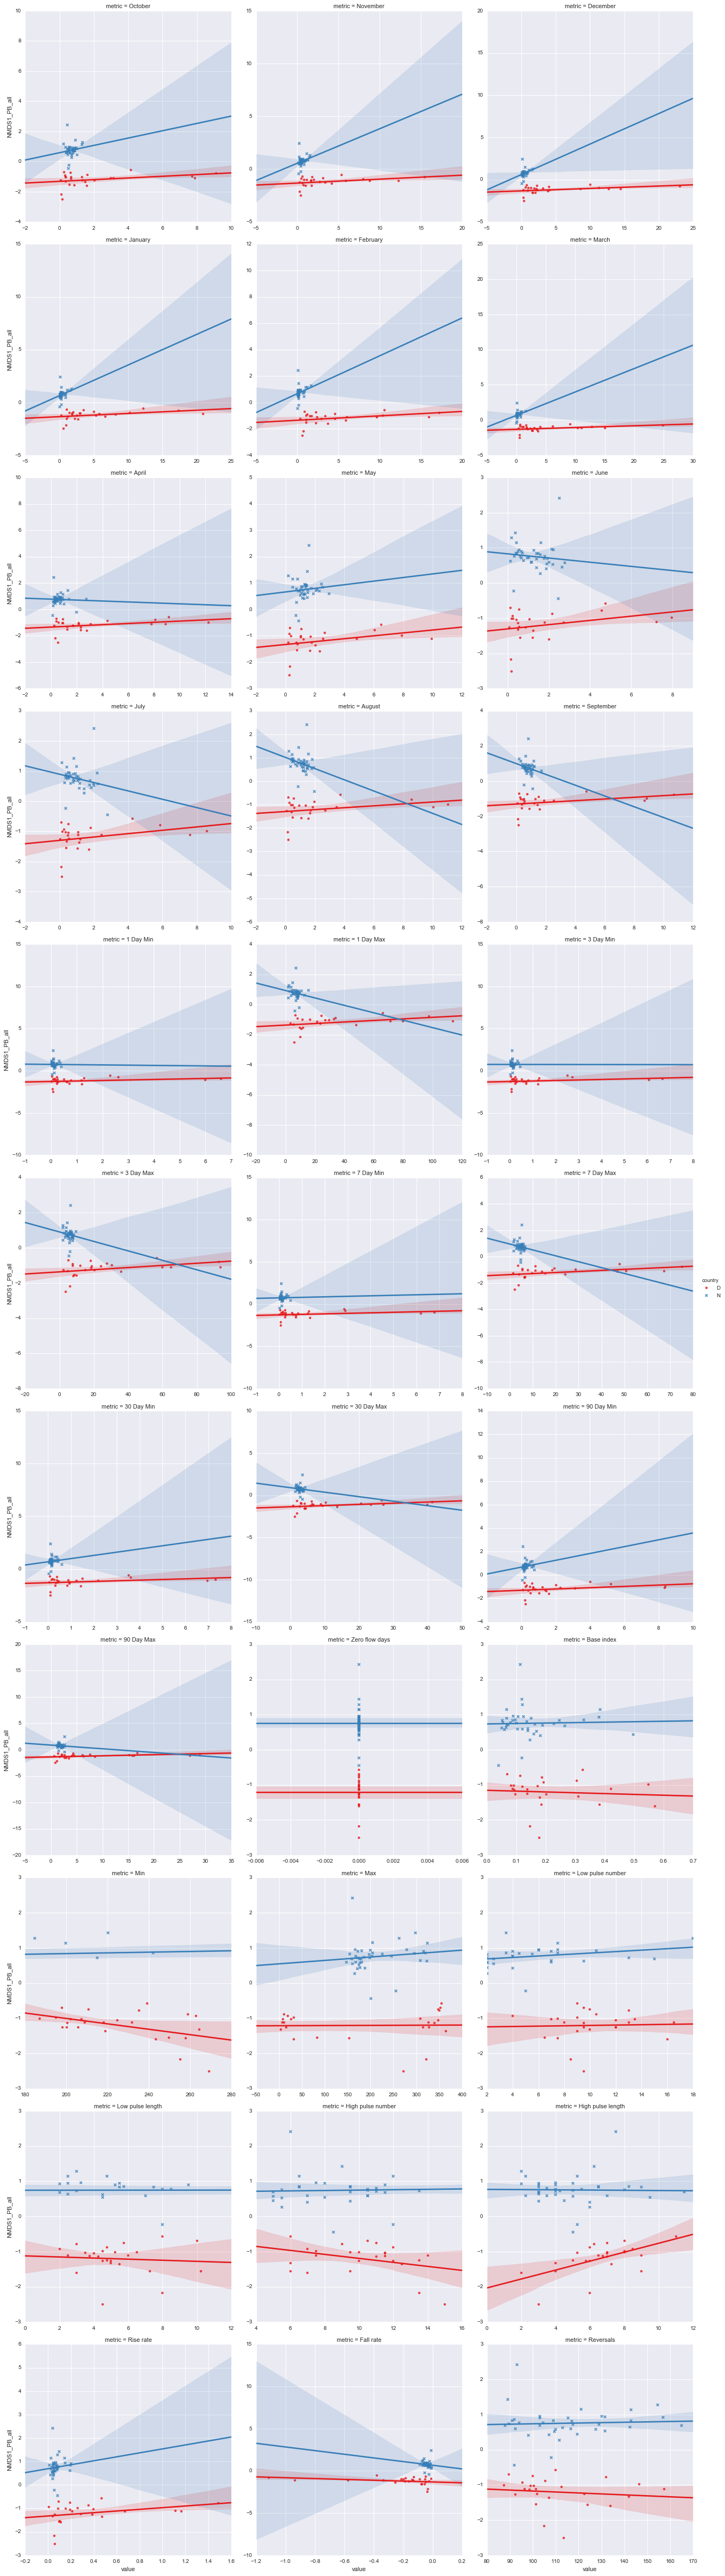

In [25]:
# NMDS1_PB versus IHA_5yr_Rel, split by country

# Convert to 'long' format
df = long_df.copy()
df = pd.melt(df, 
             id_vars=['site', 'country', 'NMDS1_PB_all', 'NMDS2_PB_all'], 
             var_name='metric')

# Factor plot
sn.lmplot(x='value', y='NMDS1_PB_all', hue='country', col='metric',
          data=df, size=6, markers=['o', 'x'], col_wrap=3,
          ci=95, palette='Set1', sharex=False, sharey=False,
          hue_order=['D', 'N']) # Seems to be a seaborn bug regarding axis limits
                                # this fudges it for now

And now repeat for NMDS2

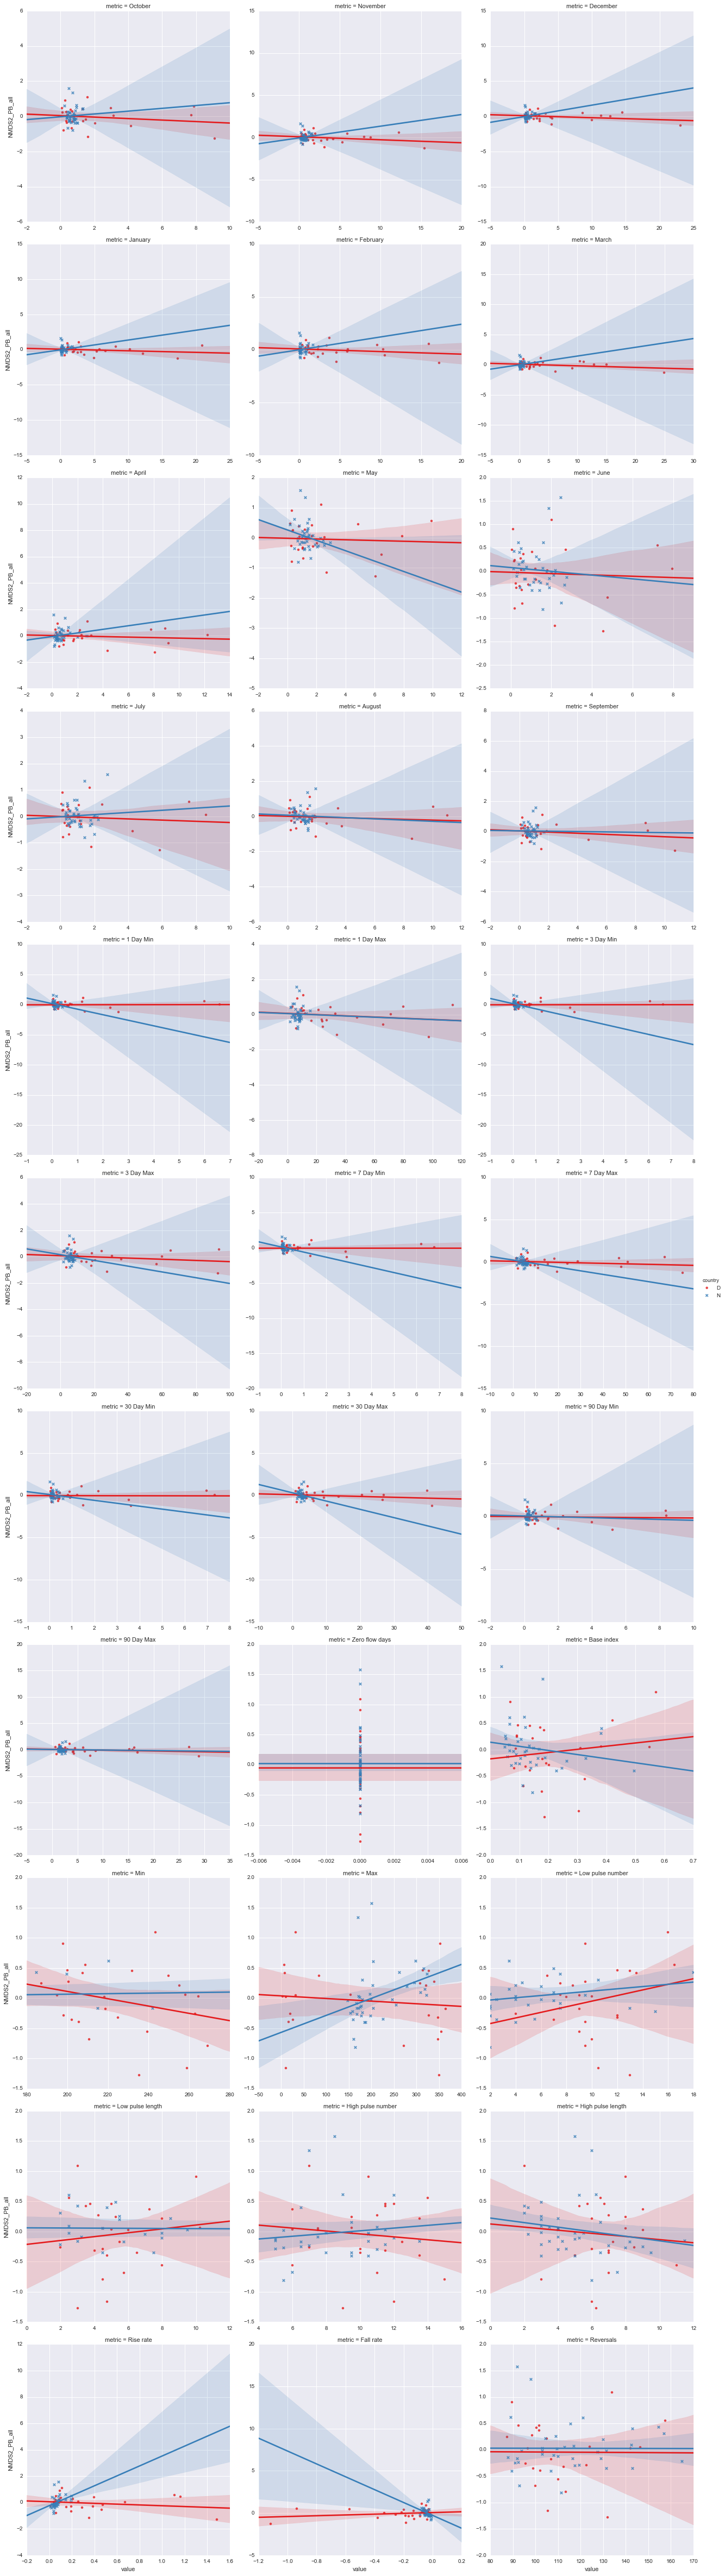

In [26]:
# Factor plot
sn.lmplot(x='value', y='NMDS2_PB_all', hue='country', col='metric',
          data=df, size=6, markers=['o', 'x'], col_wrap=3,
          ci=95, palette='Set1', sharex=False, sharey=False,
          hue_order=['D', 'N']) # Seems to be a seaborn bug regarding axis limits
                                # this fudges it for now

Due to a minor bug in `seaborn`, it looks as though some of the x-axis limits on the plots above have not been set very well. The regression lines are correct, however.

There are several cases where the data suggest a linear trend, but in most cases the relationships look very weak to me. This is especially the case for NMDS2, where there are numerous linear trends, but almost all of them with a slope of about zero. For NMDS1, the following variables look worthy of further investigation:

 * Median May flow
 * 7-, 30- and 90-day minimum flow
 * Base flow index
 * Low pulse length and number
 * High pulse length and number
 * Rise and fall rates
 * Number of reversals
 
These are explored in turn below.

##### 3.3.2. NMDS1 against median May flow

                            OLS Regression Results                            
Dep. Variable:           NMDS1_PB_all   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           2.26e-24
Time:                        17:20:09   Log-Likelihood:                -35.040
No. Observations:                  65   AIC:                             78.08
Df Residuals:                      61   BIC:                             86.78
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -1.3325    

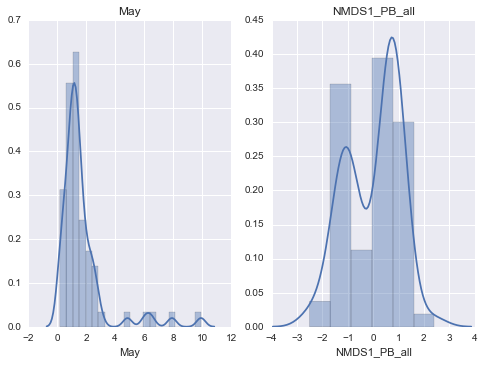

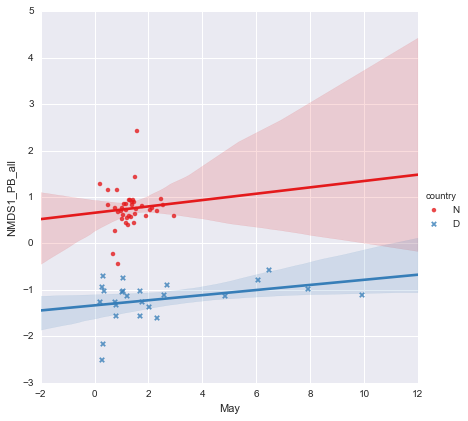

In [27]:
# Regression of NMDS1 against May, split by country
lin_reg(long_df, 'NMDS1_PB_all ~ May * C(country)', 'NMDS1_PB_all', 'May', hue='country')

The $R^2$ value is reasonable and coefficient for `C(country)[T.N]` is highly significant, emphasising the separation of the data into two groups. However, the crucial slope parameter is not significantly different from zero, implying that the May median flow has no discernable effect on the PB NMDS score.

##### 3.3.3. NMDS1 against 7-, 30- and 90-day minimum flows

These three metrics give similar results, but the relationship for 90-day averages is slightly stronger, so I've omitted the 7- and 30-day averages from the analysis below. The distribution for the 90-day explanatory variable is strongly right-skewed, so log-transforming it first seems like a good idea.

                            OLS Regression Results                            
Dep. Variable:           NMDS1_PB_all   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     111.3
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           1.05e-24
Time:                        17:20:10   Log-Likelihood:                -34.227
No. Observations:                  65   AIC:                             76.45
Df Residuals:                      61   BIC:                             85.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

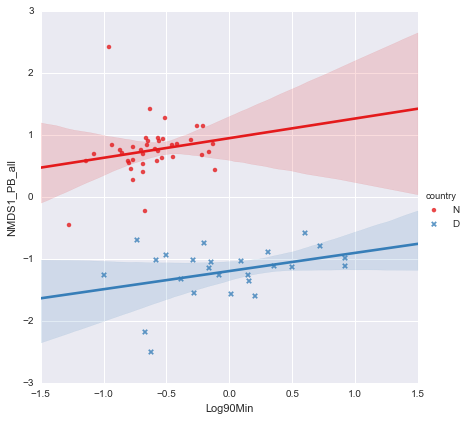

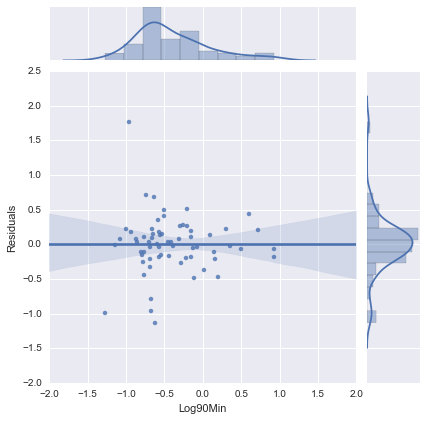

In [28]:
# Regression of NMDS1 against 90-day min, split by country

# Log transform
long_df['Log90Min'] = np.log10(long_df['90 Day Min'])

# Regression
lin_reg(long_df, 'NMDS1_PB_all ~ Log90Min * C(country)', 'NMDS1_PB_all', 'Log90Min', hue='country')

The parameter interaction term is not significant, indicating that the slope of the relationship is the same for both countries. The main slope term is also not significant at $p \leq 0.05$, but is significant at $p \leq 0.10$. The relationship is therefore poorly constrained, but **provides weak evidence that sites with higher long term minimum flows have a greater abundance/diversity of PB (as reflected by the NMDS scores)**. This makes intuitive sense, as I assume prolonged dry spells are bad for PB(?). We might also expect a similar relationship for the Base Flow Index, which should contain similar information to the 90-day average flow.

##### 3.3.3. NMDS1 against Base Flow Index

As above, the BFI distribution is right-skewed, so log-transformation seems appropriate.

                            OLS Regression Results                            
Dep. Variable:           NMDS1_PB_all   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     103.3
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           7.13e-24
Time:                        17:20:11   Log-Likelihood:                -36.271
No. Observations:                  65   AIC:                             80.54
Df Residuals:                      61   BIC:                             89.24
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -1

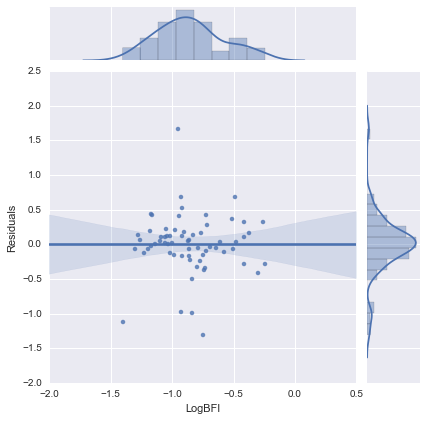

In [29]:
# Regression of NMDS1 against BFI, split by country

# Log transform
long_df['LogBFI'] = np.log10(long_df['Base index'])

lin_reg(long_df, 'NMDS1_PB_all ~ LogBFI * C(country)', 'NMDS1_PB_all', 'LogBFI', hue='country')

This relationship does look quite similar to that for the 90-day minimum, except it's (even) weaker - **the key coefficients are not significantly different from zero at any reasonable confidence level**.

##### 3.3.4. NMDS1 against Low and High Pulse Number

Low pulse number appears to have very little effect, so I've omitted the plots for brevity. High pulse number is shown below. 

                            OLS Regression Results                            
Dep. Variable:           NMDS1_PB_all   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     108.2
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           2.21e-24
Time:                        17:20:12   Log-Likelihood:                -35.018
No. Observations:                  65   AIC:                             78.04
Df Residuals:                      61   BIC:                             86.73
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

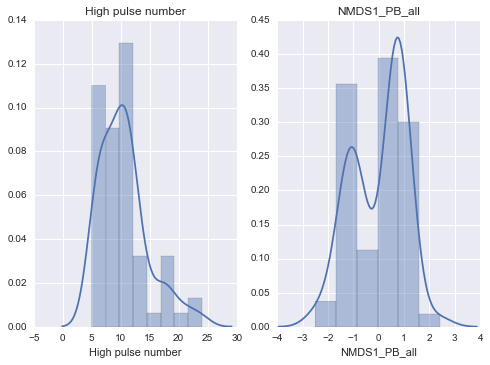

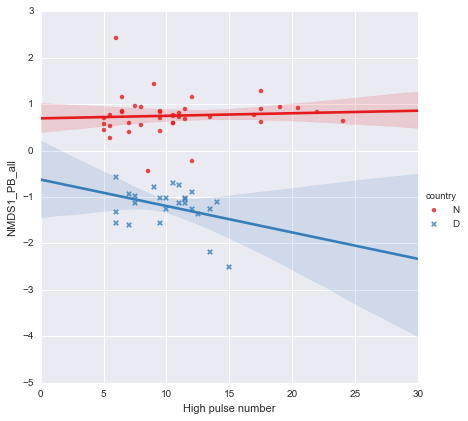

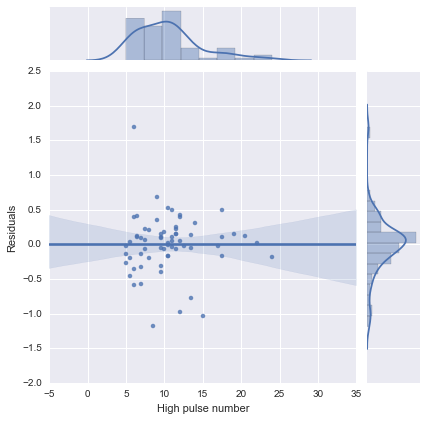

In [30]:
# Regression of NMDS1 against May, split by country
lin_reg(long_df, 'NMDS1_PB_all ~ Q("High pulse number") * C(country)', 'NMDS1_PB_all', 'High pulse number', hue='country')

**There is weak evidence (significant at $p \leq 0.10$) that a larger number of high pulses has a negative effect on the PB NMDS values for the German sites** (but not the Norwegian ones).

##### 3.3.5. NMDS1 against Low and High Pulse Length

Again, low pulse length does not seem very interesting and has been omitted. Plots for high pulse length are shown below.

                            OLS Regression Results                            
Dep. Variable:           NMDS1_PB_all   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     120.4
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           1.40e-25
Time:                        17:20:13   Log-Likelihood:                -32.070
No. Observations:                  65   AIC:                             72.14
Df Residuals:                      61   BIC:                             80.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

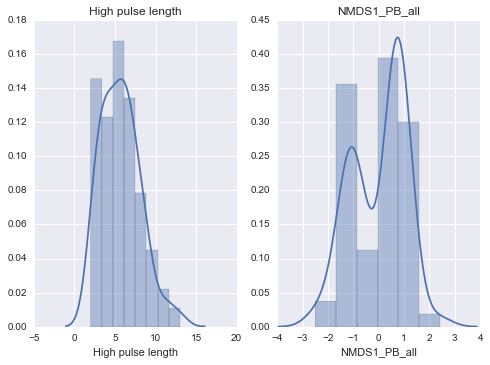

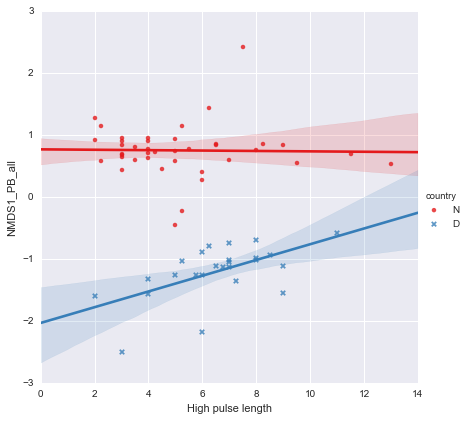

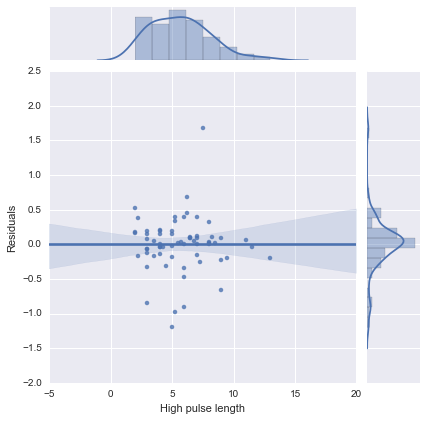

In [31]:
# Regression of NMDS1 against High pulse length, split by country
lin_reg(long_df, 'NMDS1_PB_all ~ Q("High pulse length") * C(country)', 'NMDS1_PB_all', 'High pulse length', hue='country')

**For high pulse length, there is some evidence from the German sites that longer duration high pulses are associated with larger values of NMDS1** (but the relationship does not seem to hold in Norway). 

This relationship is substantially stronger than the relationship with high pulse number (above), which appears to act in the opposite direction.

##### 3.3.6. NMDS1 against Rise Rates, Fall Rates and Reversals

None of these metrics show clear or significant relationships. In all cases, any statistically significant coefficients are so close to zero as for the strength of the relationship to be negligible.

##### 3.3.7. IHA and NMDS for MZB

I now need to repeat the whole process for the MZB data. This is all getting a bit messy, but hopefully the combinations for the MZB analysis can be guided somewhat by the results above for PB.

Start off by reading in the long-term, relative IHA statistics for the MZB sites.

In [32]:
# Read long term relative data
iha_xlsx = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG'
            r'\IHA_Params\iha_params.xlsx')
long_df = pd.read_excel(iha_xlsx, sheetname='long_term_rel_mzb')

# Add identifer for country
long_df['country'] = long_df['site'].apply(lambda x: 'N' if str(x).startswith('S') else 'D' )

# The 'name' column is not needed
del long_df['name']

# Join in NMDS1 and NMDS2 for MZB
long_df.index = long_df['site']
del long_df['site']
long_df = pd.merge(long_df, mzb_df[['NMDS1_MI_all', 'NMDS2_MI_all']], 
                   how='left', left_index=True, right_index=True)
long_df.reset_index(inplace=True)

long_df.head()

site   October  November  December   January  February     March  \
0   S109.2  0.488282  0.267673  0.193484  0.128589  0.116837  0.133095   
1  S109.21  0.619327  0.441741  0.309823  0.202087  0.163971  0.142708   
2   S109.9  0.408175  0.197541  0.117353  0.067125  0.058857  0.053659   
3  S12.137  0.839181  0.763003  0.771087  0.725656  0.710248  0.621086   
4    S12.2  0.573257  0.485983  0.261844  0.174036  0.158166  0.145911   

      April       May      June      ...       Low pulse number  \
0  0.343688  1.468724  2.651497      ...                    2.0   
1  0.247567  1.215175  1.908520      ...                    2.5   
2  0.162495  1.334429  2.769032      ...                    2.0   
3  0.470380  0.867902  1.404351      ...                   15.0   
4  0.562158  1.903437  1.146696      ...                    1.5   

   Low pulse length  High pulse number  High pulse length  Rise rate  \
0              50.5                5.0                4.5   0.049026   
1               4.5                8.0                9.5   0.034089   
2              62.0                5.0                5.0   0.039495   
3               2.0               11.5                3.0   0.048921   
4              55.5                7.0                7.0   0.053594   

   Fall rate  Reversals  country  NMDS1_MI_all  NMDS2_MI_all  
0  -0.023184      119.5        N      0.569229      0.414369  
1  -0.025441      131.5        N      0.739142      0.235288  
2  -0.020583      110.0        N      0.684756      0.369184  
3  -0.046179      165.0        N      0.699999     -0.578153  
4  -0.030547       92.5        N      0.194469      0.175090  

[5 rows x 37 columns]

Now create a factor plot for each of the IHA variables against NMDS1.

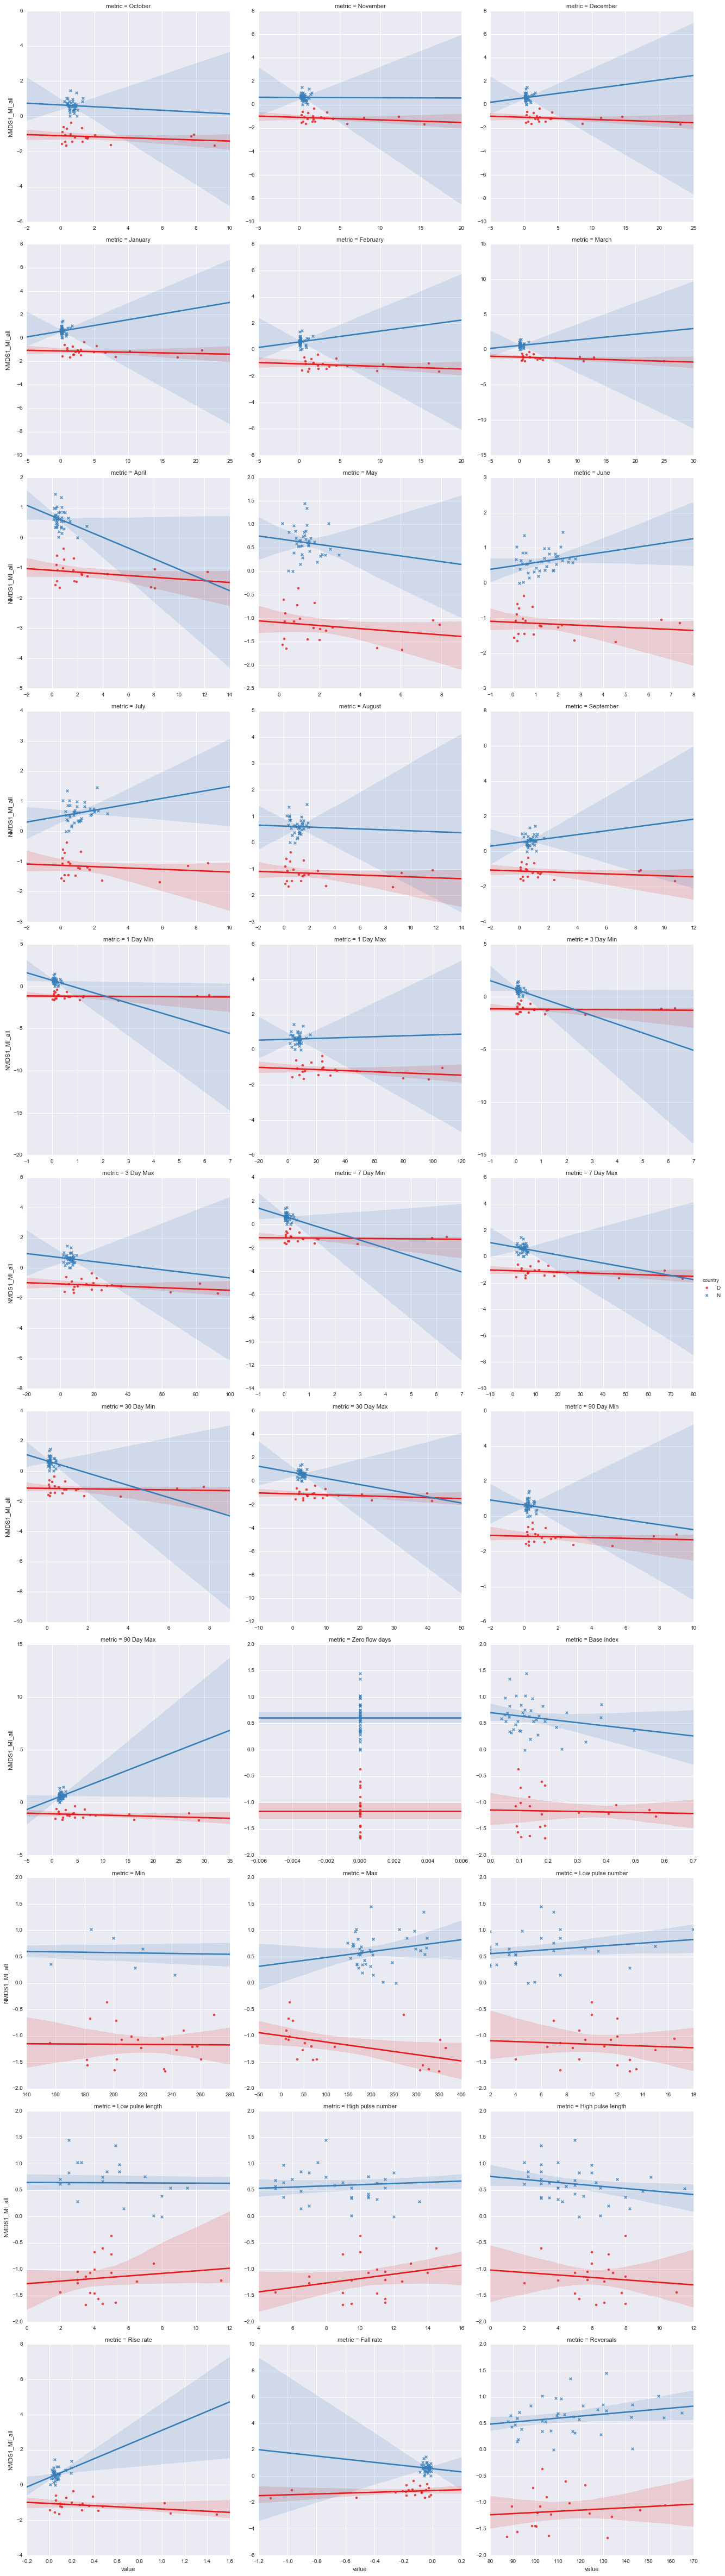

In [33]:
# NMDS1_MZB versus IHA_5yr_Rel, split by country

# Convert to 'long' format
df = long_df.copy()
df = pd.melt(df, 
             id_vars=['site', 'country', 'NMDS1_MI_all', 'NMDS2_MI_all'], 
             var_name='metric')

# Factor plot
sn.lmplot(x='value', y='NMDS1_MI_all', hue='country', col='metric',
          data=df, size=6, markers=['o', 'x'], col_wrap=3,
          ci=95, palette='Set1', sharex=False, sharey=False,
          hue_order=['D', 'N']) # Seems to be a seaborn bug regarding axis limits
                                # this fudges it for now

And now repeat the same thing for NMDS2

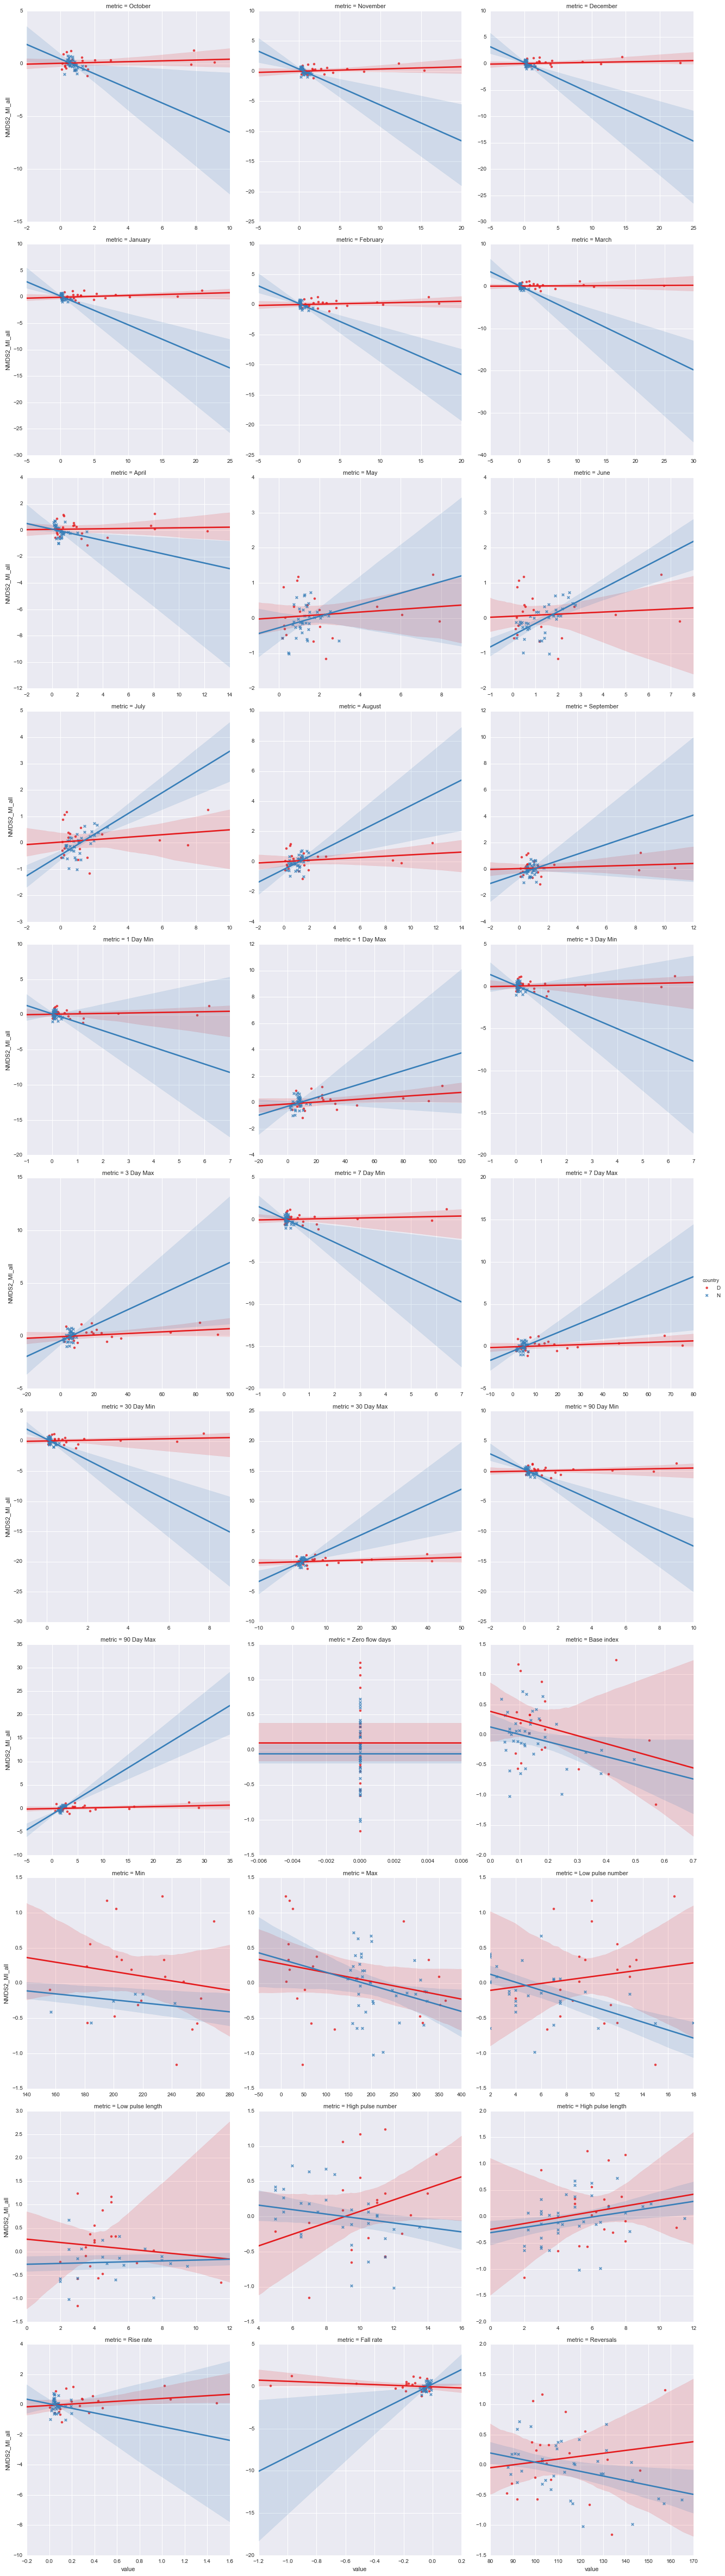

In [34]:
# Factor plot
sn.lmplot(x='value', y='NMDS2_MI_all', hue='country', col='metric',
          data=df, size=6, markers=['o', 'x'], col_wrap=3,
          ci=95, palette='Set1', sharex=False, sharey=False,
          hue_order=['D', 'N']) # Seems to be a seaborn bug regarding axis limits
                                # this fudges it for now

As with the PB analysis above, in general the regression lines for Norway are very poorly constrained, because the IHA parameters for the Norwegian sites tend to be very similar, so they cluster together on the plots. The German sites are generally more hydrologically variable, leading to better regressions.

Of all the plots above, only the following for NMDS1 seem interesting at first glance:

 * Base Flow Index
 * High pulse length and number
 * Number of reversals
 
Let's look at each in turn.

##### 3.3.8. NMDS1 against Base Flow Index

BFI is right-skewed, so log-transform first.

                            OLS Regression Results                            
Dep. Variable:           NMDS1_MI_all   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     131.1
Date:                Tue, 14 Jun 2016   Prob (F-statistic):           1.49e-25
Time:                        17:20:34   Log-Likelihood:                -17.310
No. Observations:                  61   AIC:                             42.62
Df Residuals:                      57   BIC:                             51.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -1

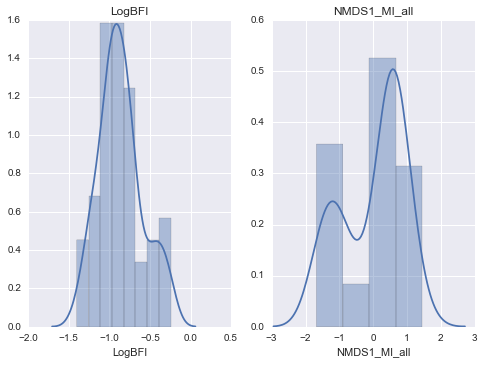

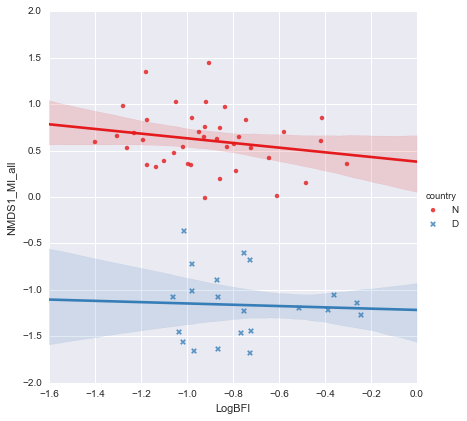

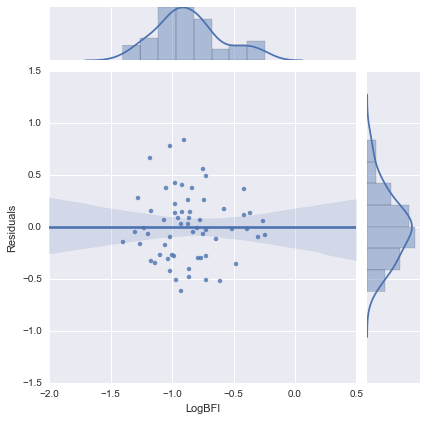

In [35]:
# Regression of NMDS1 against High pulse length, split by country
long_df['LogBFI'] = np.log10(long_df['Base index'])
lin_reg(long_df, 'NMDS1_MI_all ~ LogBFI * C(country)', 'NMDS1_MI_all', 'LogBFI', hue='country')

This regression achieves a reasonable $R^2$, but the coefficients are not significantly different from zero.

##### 3.3.9. NMDS1 against High Pulse Number, High Pulse Length and Reversals

I've tried all of these, and although they all produce reasonable $R^2$ values, none of the coefficients are significantly different from zero at any reasonable confidence level. The plots are not shown below to save space.

### 4. Summary

This notebook is becoming long and messy, so I'll summarise what I've found so far and move on to a different approach next time in a new workbook. The main results so far are:

 1. The IHA methodology is not designed to work with short time series (less than a few years in length). To consider flow indices for e.g. one year prior to ecological sampling, I will need to modify/recode the IHA statistics from scratch, rather than relying on the existing R package or the IHA software. <br><br>
 
 2. To begin with, I've followed Susi's approach of plotting explanatory variables against NMDS scores and looking for significant, similar relationships between Germany and Norway. The relationships identified so far are:
 
    * A **negative relationship** between NMDS1_PB and pH, using separate regression lines for each country (as originally identifed by Susi). <br><br>
       
    * **No relationship** between NMDS2_PB and TP. This was highlighted as a possible trend in Susi's preliminary analysis, but the regression coefficients are not significantly different from zero. <br><br>
         
    * A **weak positive relationship** between NMDS1_PB and the minimum flow averaged over a 90-day moving window (using a separate regression line for each country). In other words, sites with higher minimum flows relative to the average tend to have higher NMDS1_PB scores. <br><br>
       
    * For Germany only, a **positive relationship** between NMDS1_PB and the *duration* of high flow pulses. This is confounded to some extent by a **weaker negative relationship** between NMDS1_PB and the *number* of high flow pulses. <br><br>
       
    * A **weak negative relationship** between NMDS1_MZB and TOC, using a separate regression line for each country (this one was also originally identified by Susi). Note that, although statistically significant, the relationship is **so weak that it's likely ecologically negligible**. <br><br>
       
    * A **weak positive relationship** between NMDS2_MZB and pH, using a single regression line for the entire dataset. Again, this possibility was originally identified by Susi but, although it's just about statistically significant, I think the relationship is **so weak as to be essentially negligible**. <br><br>
     
    * **No significant relationships** at all between the NMDS scores for MZB and the 5 year IHA parameters.
    
I'll go through all this a bit more thoroughly at some point, but I think the next step is to try some dimensionality reduction techniques to bring out any major patterns in the datasets, and to reduce the number of possible combinations of explanatory and response variables (which are a bit overwhelming at the moment).